# Laboratory Practice: Implementing Autoencoders on MNIST and FMNIST Databases

------------------------------------------------------
*Pablo Gradolph Oliva*

*Raquel Parajuá Delgado*

------------------------------------------------------

## 1. Introduction

In this laboratory practice, we will focus on the implementation and experimentation with deep autoencoders using the MNIST and Fashion-MNIST (FMNIST) datasets. Autoencoders are a class of neural networks used for unsupervised learning, capable of learning efficient representations (compressions) of the input data. This compression is achieved through an encoding process, where the input data is transformed into a lower-dimensional representation, followed by a decoding process, where the representation is used to reconstruct the input.

The main goal of this lab is to explore how the dimension of the latent space affects the compression and reconstruction ability of an autoencoder. We will compare autoencoder architectures with different numbers of layers (3 vs 5) and sizes of latent space (15, 30, 50, 100) to evaluate their performance in encoding and reconstructing images. Additionally, we will apply regularization techniques, such as Lasso regularization, to improve model generalization.

Subsequently, we will enhance our autoencoder architecture by introducing denoising capabilities through the implementation of a denoising autoencoder. This will allow us to assess the effectiveness of autoencoders not only in compression and reconstruction but also in their ability to clean noisy images.

Finally, we will use the Peak Signal-to-Noise Ratio (PSNR) as a performance metric to evaluate our models and visualize the results of reconstruction and denoising to gain a deeper understanding of the capabilities of our autoencoders.

In [53]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## 2. MNIST

### 2.1. Download MNIST

In [54]:
# transform = transforms.ToTensor() # -> Values between 0 and 1 Sigmoid() in the decoder.

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ]) # -> Values between -1 and 1 Tanh() in the decoder.

# Download and load the training  data
train_set = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

# Download and load the test data
test_set = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

We check that our values are in [-1, 1], therefore, we will apply Tanh() in the decoder

In [55]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(-1.) tensor(1.)


### 2.2. 3-Layer Autoencoder

In this step we create our autoencoder with 3 layers in both the encoder and the decoder. Keep in mind that the input images in MNIST have a dimension of 28x28 and we want to reduce them in the encoder to the projected dimension that we pass as an argument (15, 30, 50, 100) for our case.

In [56]:
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim=3):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),          # First layer: input to 256
            nn.ReLU(),
            nn.Linear(256, 144),            # Second layer: 256 to 144
            nn.ReLU(),
            nn.Linear(144, encoding_dim)    # Third layer: 144 to encoding_dim
        ) 
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 144),   # First layer: encoding_dim to 144
            nn.ReLU(),
            nn.Linear(144, 256),            # Second layer: 144 to 256
            nn.ReLU(),
            nn.Linear(256, 28*28),          # Third layer: 256 to input dimensions
            nn.Tanh()                       # We can use nn.Sigmoid() if necessary.
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Example:
model = Autoencoder(15)
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=144, bias=True)
    (3): ReLU()
    (4): Linear(in_features=144, out_features=15, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=144, bias=True)
    (1): ReLU()
    (2): Linear(in_features=144, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Tanh()
  )
)


### 2.3. Training of an Autoencoder Model using PyTorch.

Define the loss criterion as the Mean Squared Error (MSE). In the context of an autoencoder, this measures how different the reconstruction is from the original input and is used to guide model learning.

In [57]:
criterion = nn.MSELoss()

#### 2.3.1. Optimizer and Regularization

Initializes the optimizer that will be used to adjust the model parameters. Here we use Adam, a popular optimizer that adjusts the weights more efficiently than simpler gradient descent methods. lr=1e-3 sets the learning rate, which controls how much the model weights are adjusted at each update step.

We will apply the L1 (Lasso) and L2 (Ridge) regularizations simultaneously, a practice known as Elastic Net. Elastic Net combines the properties of both regularizations, taking advantage of L1's feature selection capability and L2's ability to penalize weights without removing them completely. This is done by adding both L1 and L2 penalty terms to the loss function, each weighted by its own regularization parameter.

L2 regularization is easily implemented by the weight_decay argument in most of the optimizers in PyTorch, including Adam.

We will use this function to train our models, both 3 layers and 5 layers. By changing and adjusting the parameters passed as arguments.

In [58]:
def train_autoencoder(model, train_loader, criterion=criterion, num_epochs=10, lambda_l1=1e-5, weight_decay=1e-5):
    # lambda_l1 is the regularization coefficient Lasso
    
    # optimizer = optim.Adam(model.parameters(), lr=1e-3) # Without using any regularization
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=weight_decay)  # L2 regularization (Ridge)

    outputs = []
    for epoch in range(num_epochs):
        for (img, _) in train_loader:
            img = img.reshape(-1, 28*28)
            recon = model(img)

            # Calculate the basic loss
            loss = criterion(recon, img)
            
            # Calculates the L1 regularization (sum of the absolute values of the weights).
            l1_penalty = torch.tensor(0.).to(img.device)
            for param in model.parameters():
                l1_penalty += torch.sum(torch.abs(param))
            
            # Adds the L1 loss to the original loss
            total_loss = loss + lambda_l1 * l1_penalty

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Total Loss: {total_loss.item():.4f}')
        outputs.append((epoch, img, recon))
    
    return outputs
    

We will use this other function to see the results obtained, we will represent the autoencoder input and the representation for each 4 training laps so that a difference can be seen.

In [59]:
def visualize_reconstructions(outputs, interval=4):
    for k in range(0, len(outputs), interval):
        plt.figure(figsize=(9, 2))
        plt.gray()
        imgs = outputs[k][1].detach().numpy()
        recon = outputs[k][2].detach().numpy()

        plt.suptitle(f'Epoch {k+1}', fontsize=16)

        for i, item in enumerate(imgs):
            if i >= 9: break
            plt.subplot(2, 9, i+1)
            item = item.reshape(-1, 28,28) # item: 1, 28, 28
            plt.imshow(item[0])
            plt.axis('off')
                
        for i, item in enumerate(recon):
            if i >= 9: break
            plt.subplot(2, 9, 9+i+1) # row_length + i + 1
            item = item.reshape(-1, 28,28)
            plt.imshow(item[0])
            plt.axis('off')

### 2.4. Results.

#### 2.4.1 Projected dimension = 15.

Epoch [1/10], Loss: 0.0865, Total Loss: 0.1941
Epoch [2/10], Loss: 0.0574, Total Loss: 0.1674
Epoch [3/10], Loss: 0.0518, Total Loss: 0.1612
Epoch [4/10], Loss: 0.0485, Total Loss: 0.1601
Epoch [5/10], Loss: 0.0528, Total Loss: 0.1660
Epoch [6/10], Loss: 0.0420, Total Loss: 0.1577
Epoch [7/10], Loss: 0.0436, Total Loss: 0.1602
Epoch [8/10], Loss: 0.0459, Total Loss: 0.1630
Epoch [9/10], Loss: 0.0558, Total Loss: 0.1742
Epoch [10/10], Loss: 0.0479, Total Loss: 0.1671


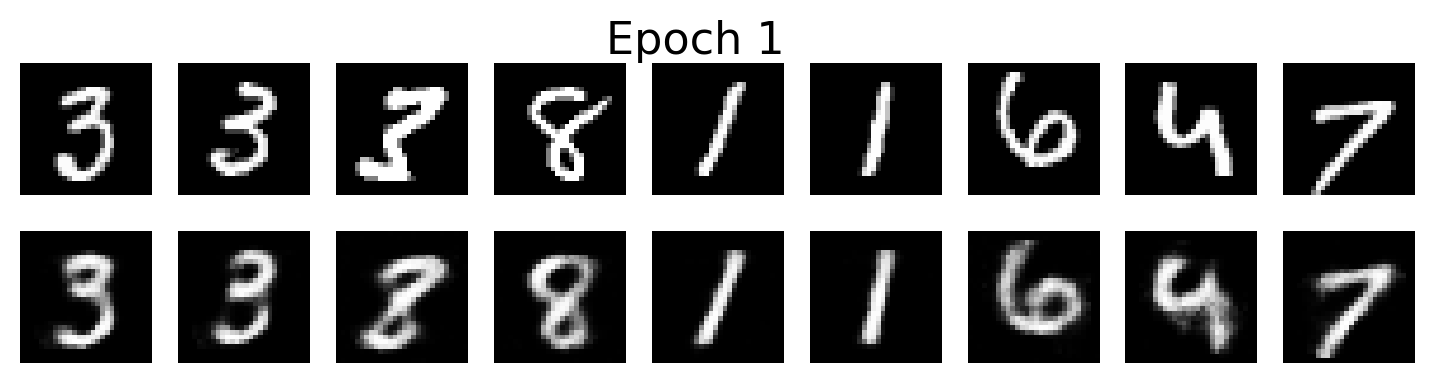

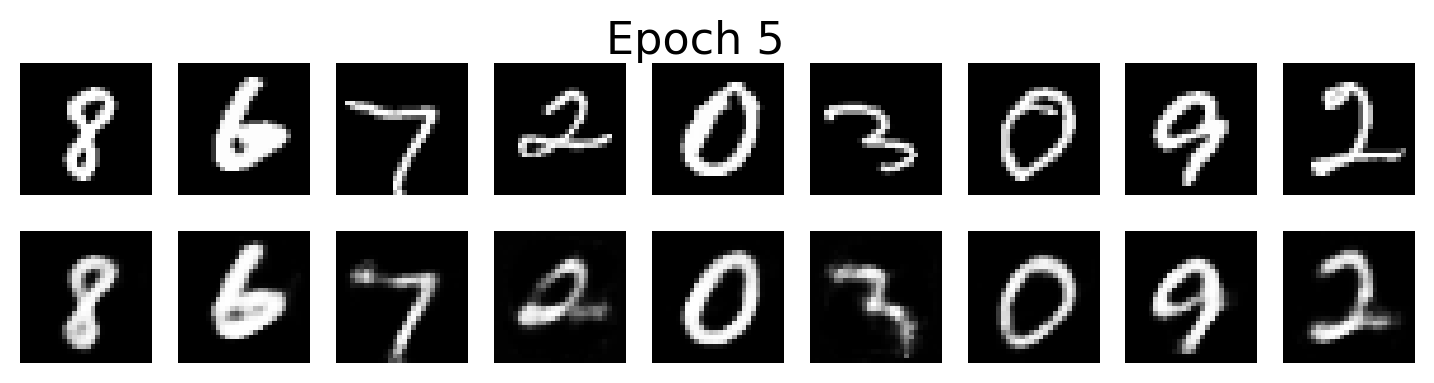

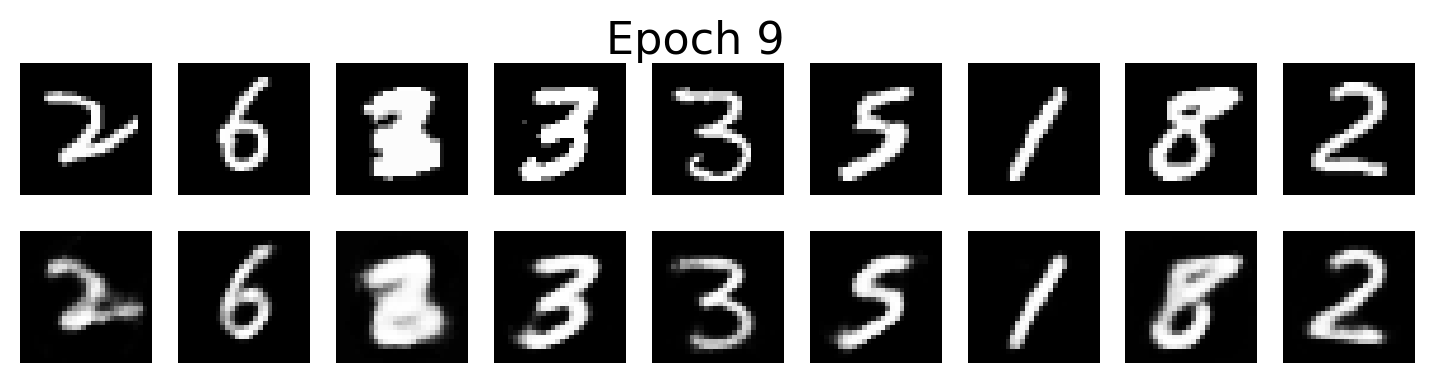

In [22]:
model = Autoencoder(15)
outputs = train_autoencoder(model, train_loader)
visualize_reconstructions(outputs)

#### 2.4.2 Projected dimension = 30.

Epoch [1/10], Loss: 0.0690, Total Loss: 0.1747
Epoch [2/10], Loss: 0.0594, Total Loss: 0.1662
Epoch [3/10], Loss: 0.0535, Total Loss: 0.1621
Epoch [4/10], Loss: 0.0394, Total Loss: 0.1498
Epoch [5/10], Loss: 0.0359, Total Loss: 0.1478
Epoch [6/10], Loss: 0.0354, Total Loss: 0.1477
Epoch [7/10], Loss: 0.0315, Total Loss: 0.1440
Epoch [8/10], Loss: 0.0319, Total Loss: 0.1445
Epoch [9/10], Loss: 0.0328, Total Loss: 0.1469
Epoch [10/10], Loss: 0.0272, Total Loss: 0.1415


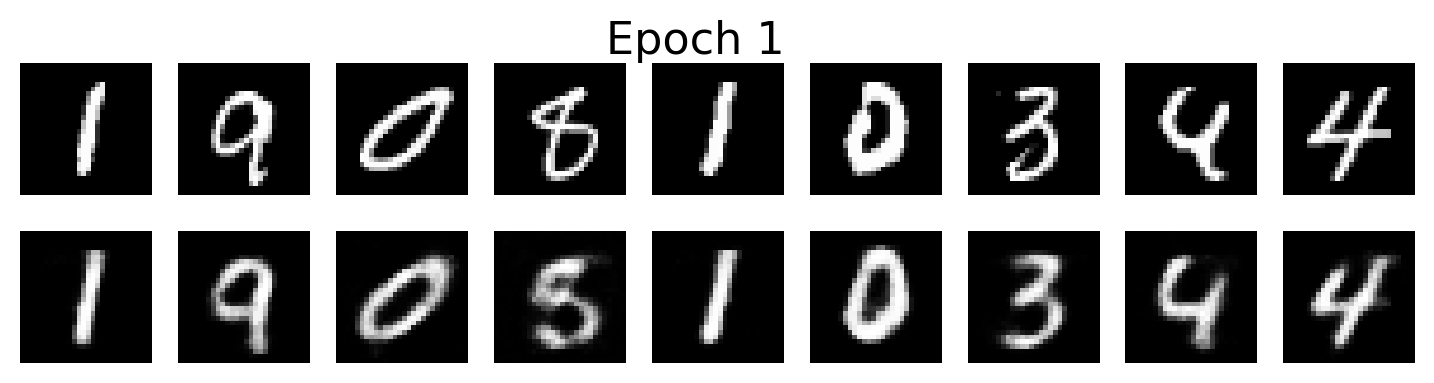

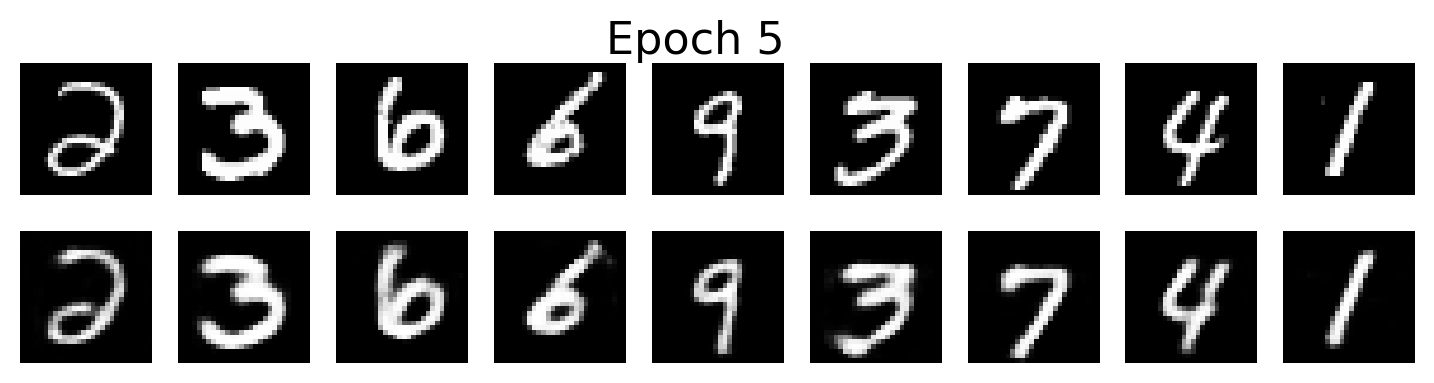

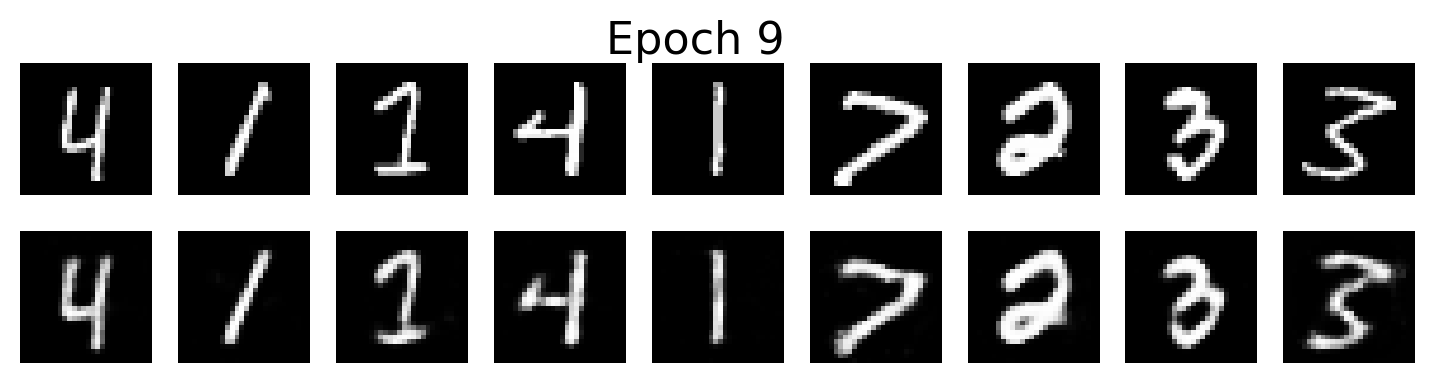

In [8]:
model = Autoencoder(30)
outputs = train_autoencoder(model, train_loader)
visualize_reconstructions(outputs)

#### 2.4.3 Projected dimension = 50.

Epoch [1/10], Loss: 0.0628, Total Loss: 0.1672
Epoch [2/10], Loss: 0.0552, Total Loss: 0.1597
Epoch [3/10], Loss: 0.0453, Total Loss: 0.1511
Epoch [4/10], Loss: 0.0415, Total Loss: 0.1485
Epoch [5/10], Loss: 0.0407, Total Loss: 0.1493
Epoch [6/10], Loss: 0.0351, Total Loss: 0.1444
Epoch [7/10], Loss: 0.0295, Total Loss: 0.1395
Epoch [8/10], Loss: 0.0276, Total Loss: 0.1376
Epoch [9/10], Loss: 0.0258, Total Loss: 0.1355
Epoch [10/10], Loss: 0.0313, Total Loss: 0.1424


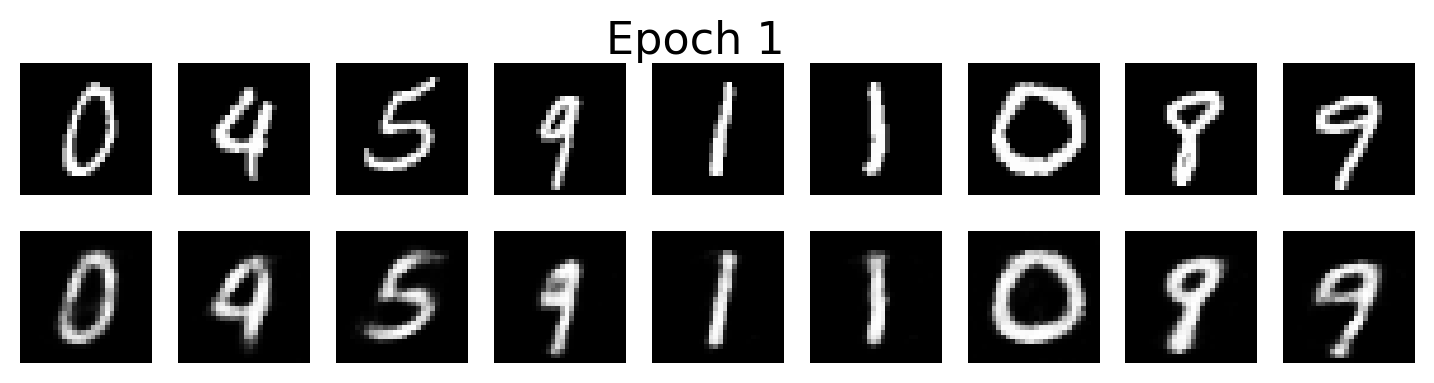

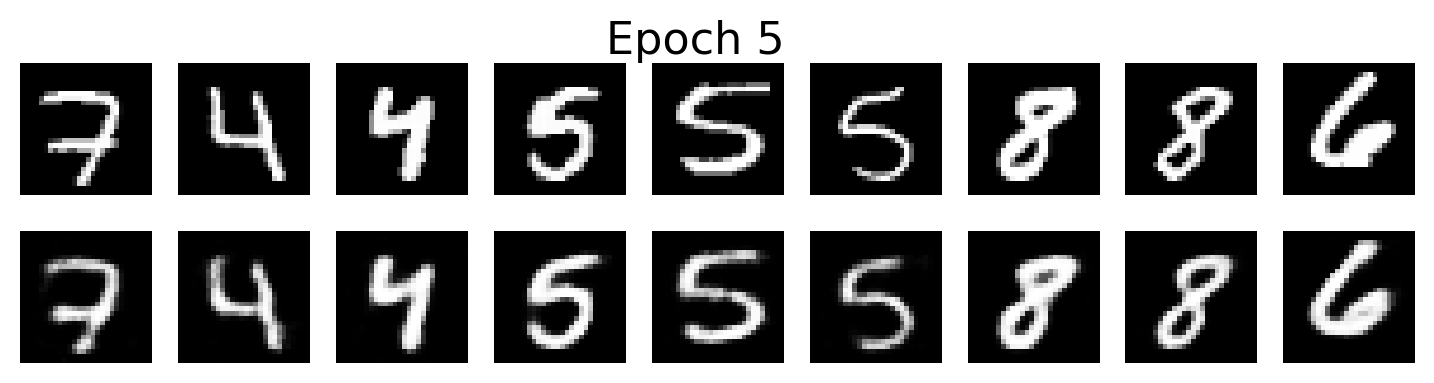

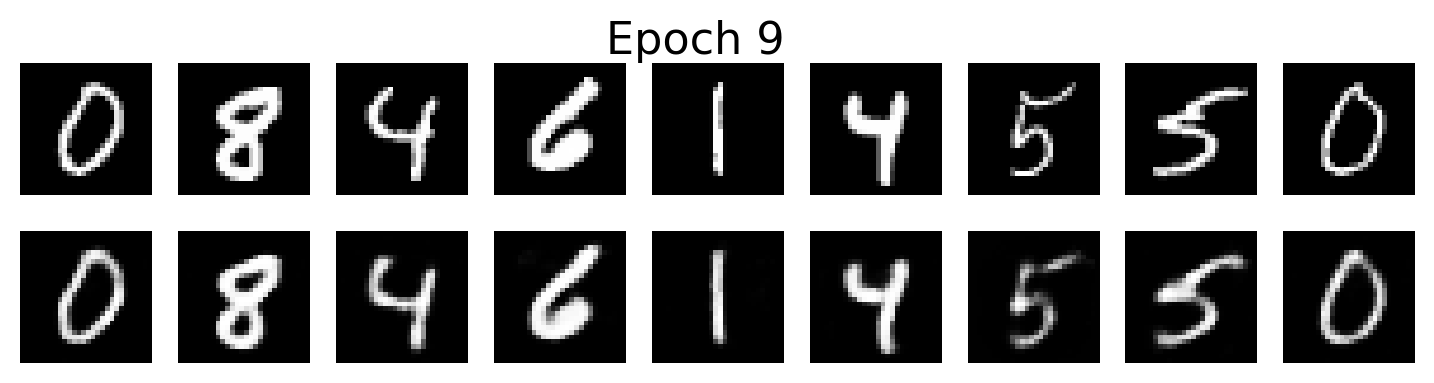

In [9]:
model = Autoencoder(50)
outputs = train_autoencoder(model, train_loader)
visualize_reconstructions(outputs)

#### 2.4.4 Projected dimension = 100.

Epoch [1/10], Loss: 0.0739, Total Loss: 0.1796
Epoch [2/10], Loss: 0.0555, Total Loss: 0.1613
Epoch [3/10], Loss: 0.0430, Total Loss: 0.1490
Epoch [4/10], Loss: 0.0368, Total Loss: 0.1428
Epoch [5/10], Loss: 0.0325, Total Loss: 0.1406
Epoch [6/10], Loss: 0.0335, Total Loss: 0.1409
Epoch [7/10], Loss: 0.0298, Total Loss: 0.1386
Epoch [8/10], Loss: 0.0281, Total Loss: 0.1377
Epoch [9/10], Loss: 0.0311, Total Loss: 0.1403
Epoch [10/10], Loss: 0.0261, Total Loss: 0.1369


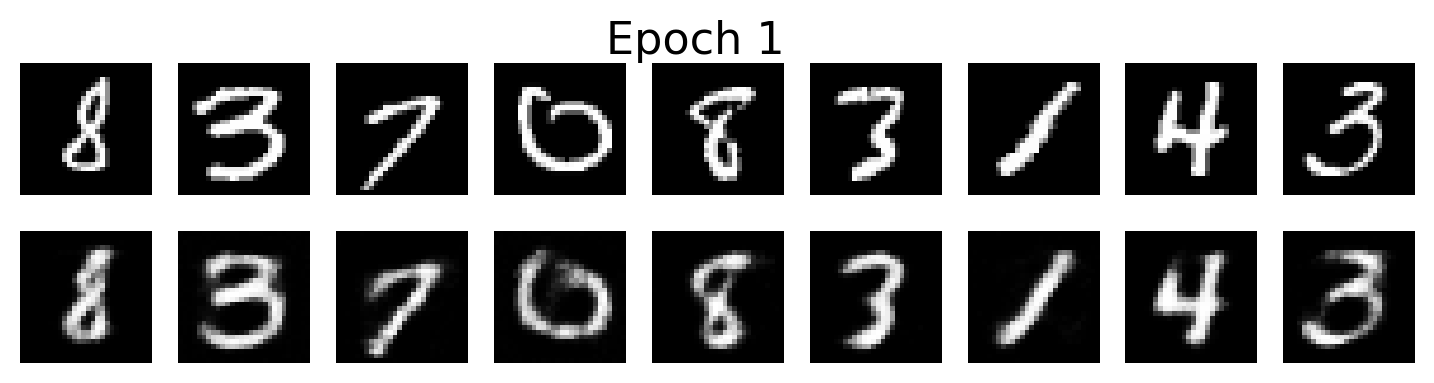

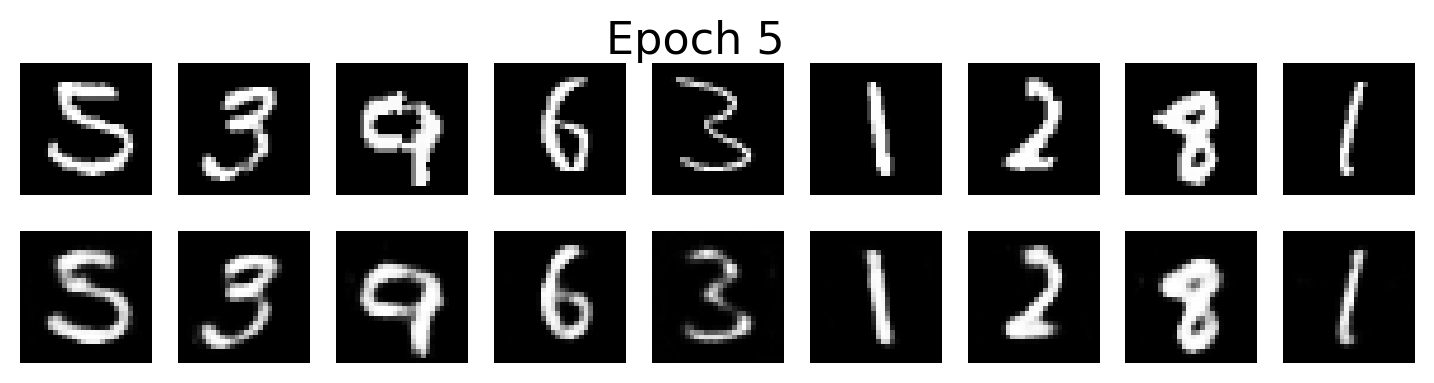

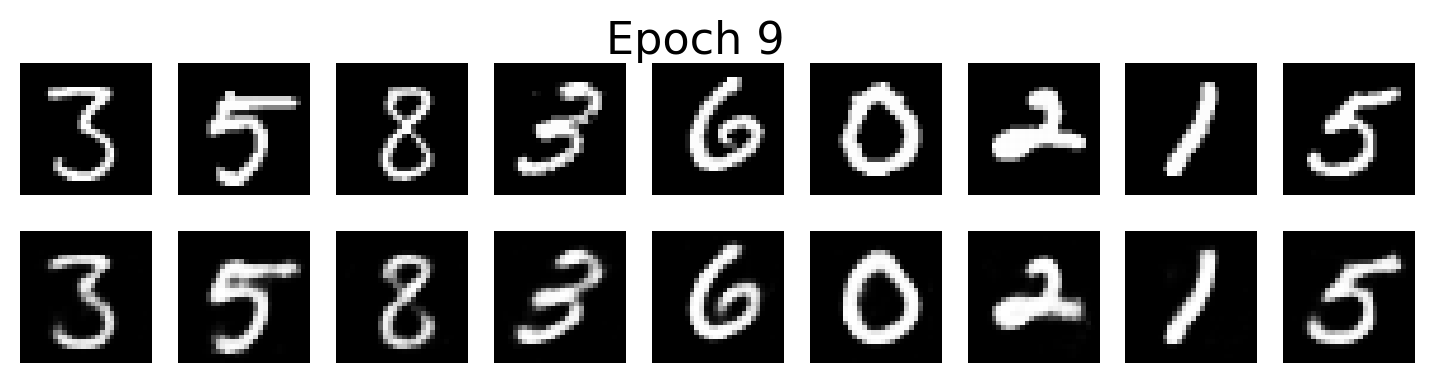

In [10]:
model = Autoencoder(100)
outputs = train_autoencoder(model, train_loader)
visualize_reconstructions(outputs)

### 2.5. 5-Layer Autoencoder

In this step we will replicate the previous steps but for a 5 layer autoencoder. We will see how this may affect the results obtained.

Rerun the data download code if necessary.

In [60]:
# transform = transforms.ToTensor() # -> Values between 0 and 1 Sigmoid() in the decoder.

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ]) # -> Values between -1 and 1 Tanh() in the decoder.

# Download and load the training  data
train_set = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

# Download and load the test data
test_set = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

In [61]:
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim=3):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 640),           # First layer: input to 640
            nn.ReLU(),
            nn.Linear(640, 512),             # Second layer: 640 to 512
            nn.ReLU(),
            nn.Linear(512, 256),             # Third layer: 512 to 256
            nn.ReLU(),
            nn.Linear(256, 144),             # Fourth layer: 256 to 144
            nn.ReLU(),
            nn.Linear(144, encoding_dim)     # Fifth layer: 144 to encoding_dim (space latent)
        ) 
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 144),    # First layer: encoding_dim to 144
            nn.ReLU(),
            nn.Linear(144, 256),             # Second layer: 144 to 256
            nn.ReLU(),
            nn.Linear(256, 512),            # Third layer: 256 to 512
            nn.ReLU(),
            nn.Linear(512, 640),            # Fourth layer: 512 to 640
            nn.ReLU(),
            nn.Linear(640, 28*28),          # Fifth layer: 640 to input dimensions
            nn.Tanh()                       # We can use nn.Sigmoid() if necessary.
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Example usage:
model = Autoencoder(15)
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=640, bias=True)
    (1): ReLU()
    (2): Linear(in_features=640, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=144, bias=True)
    (7): ReLU()
    (8): Linear(in_features=144, out_features=15, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=144, bias=True)
    (1): ReLU()
    (2): Linear(in_features=144, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=640, bias=True)
    (7): ReLU()
    (8): Linear(in_features=640, out_features=784, bias=True)
    (9): Tanh()
  )
)


#### 2.5.1. Train the 5-Layer Autoencoder and Results

We are going to use the same functions as before but adjusting certain parameters to obtain better trained models in the case of 5 layers.

In [62]:
criterion = nn.MSELoss()

#### 2.5.2 Projected dimension = 15.

Epoch [1/15], Loss: 0.1282, Total Loss: 0.1316
Epoch [2/15], Loss: 0.0881, Total Loss: 0.0917
Epoch [3/15], Loss: 0.0770, Total Loss: 0.0809
Epoch [4/15], Loss: 0.0821, Total Loss: 0.0863
Epoch [5/15], Loss: 0.0695, Total Loss: 0.0738
Epoch [6/15], Loss: 0.0656, Total Loss: 0.0701
Epoch [7/15], Loss: 0.0727, Total Loss: 0.0773
Epoch [8/15], Loss: 0.0570, Total Loss: 0.0618
Epoch [9/15], Loss: 0.0553, Total Loss: 0.0602
Epoch [10/15], Loss: 0.0560, Total Loss: 0.0610
Epoch [11/15], Loss: 0.0601, Total Loss: 0.0653
Epoch [12/15], Loss: 0.0489, Total Loss: 0.0542
Epoch [13/15], Loss: 0.0556, Total Loss: 0.0610
Epoch [14/15], Loss: 0.0473, Total Loss: 0.0528
Epoch [15/15], Loss: 0.0599, Total Loss: 0.0654


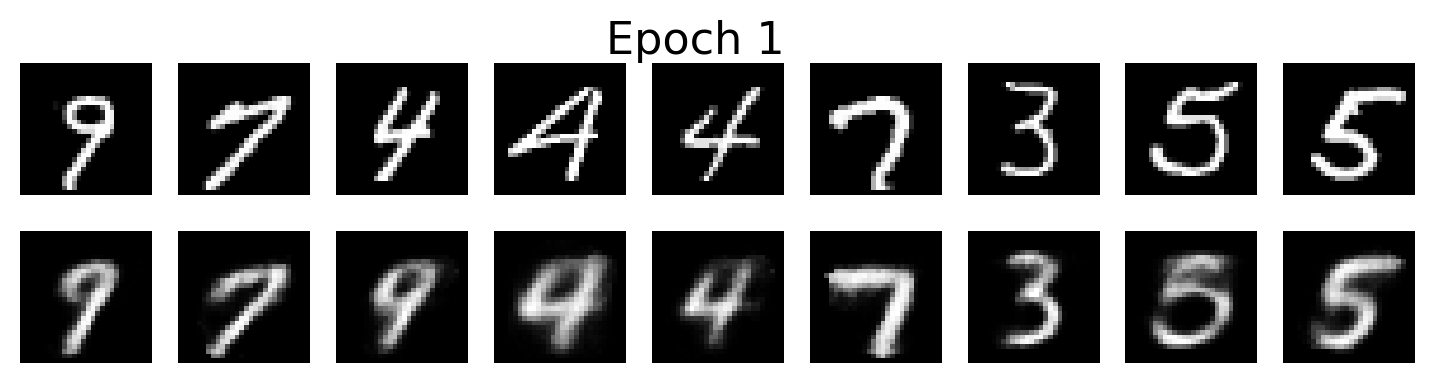

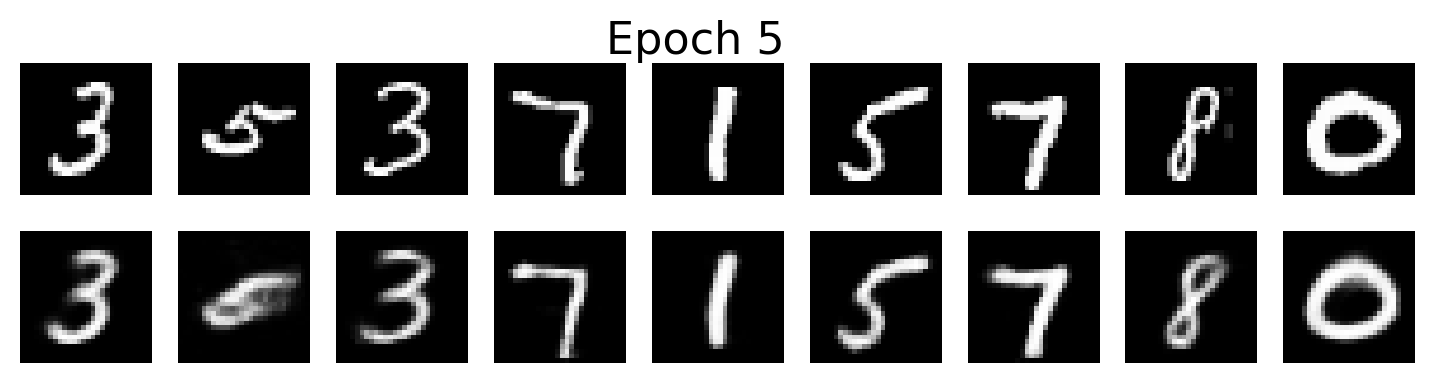

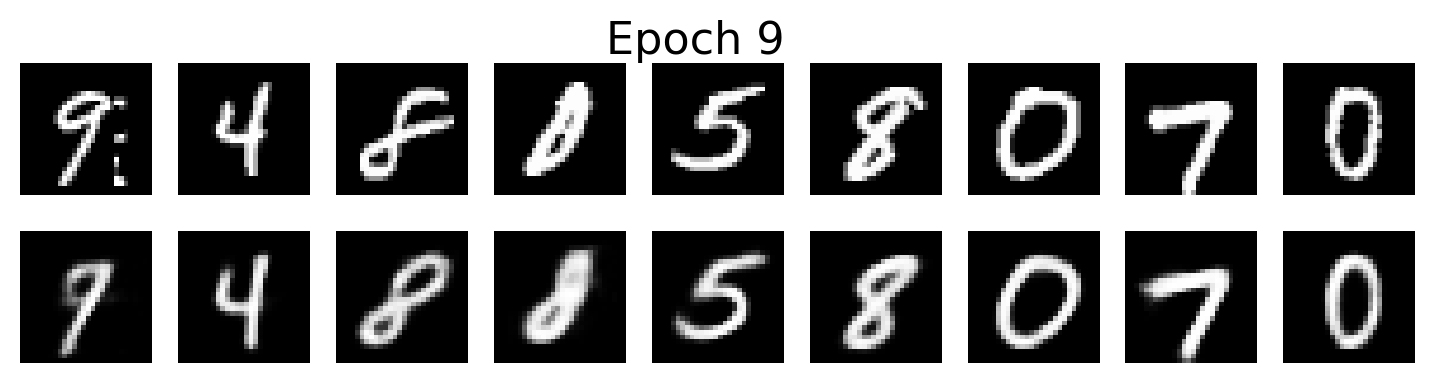

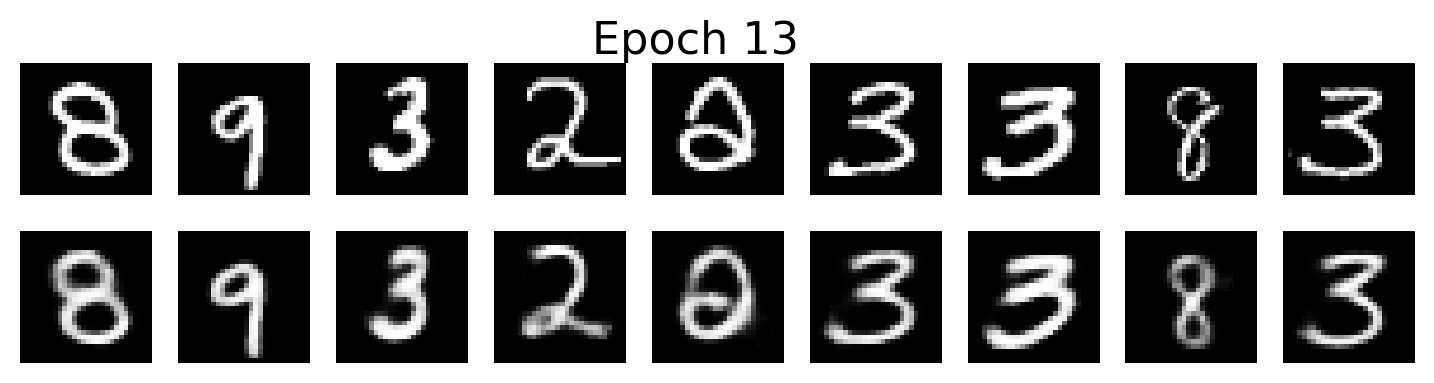

In [23]:
model = Autoencoder(15)
outputs = train_autoencoder(model, train_loader, num_epochs=13, lambda_l1=1e-7, weight_decay=1e-7)
visualize_reconstructions(outputs)

#### 2.5.3 Projected dimension = 30.

Epoch [1/13], Loss: 0.1165, Total Loss: 0.1198
Epoch [2/13], Loss: 0.0904, Total Loss: 0.0941
Epoch [3/13], Loss: 0.0917, Total Loss: 0.0956
Epoch [4/13], Loss: 0.0821, Total Loss: 0.0863
Epoch [5/13], Loss: 0.0675, Total Loss: 0.0719
Epoch [6/13], Loss: 0.0636, Total Loss: 0.0681
Epoch [7/13], Loss: 0.0593, Total Loss: 0.0639
Epoch [8/13], Loss: 0.0693, Total Loss: 0.0740
Epoch [9/13], Loss: 0.0622, Total Loss: 0.0670
Epoch [10/13], Loss: 0.0603, Total Loss: 0.0653
Epoch [11/13], Loss: 0.0516, Total Loss: 0.0566
Epoch [12/13], Loss: 0.0578, Total Loss: 0.0629
Epoch [13/13], Loss: 0.0485, Total Loss: 0.0537


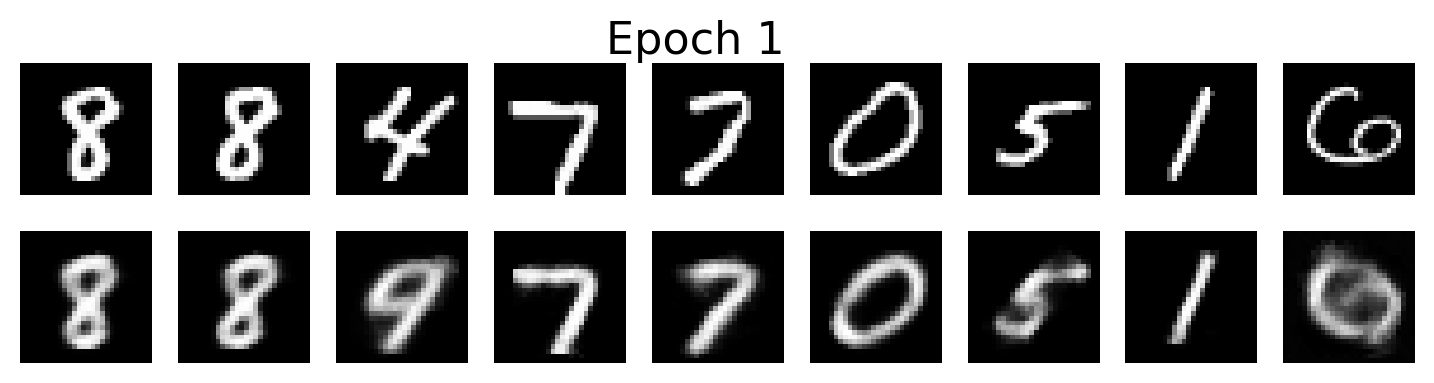

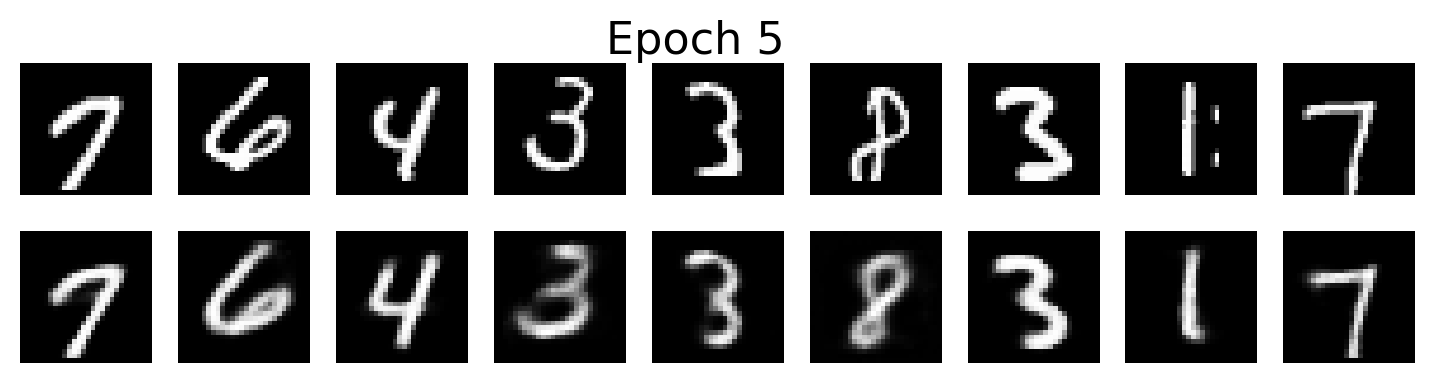

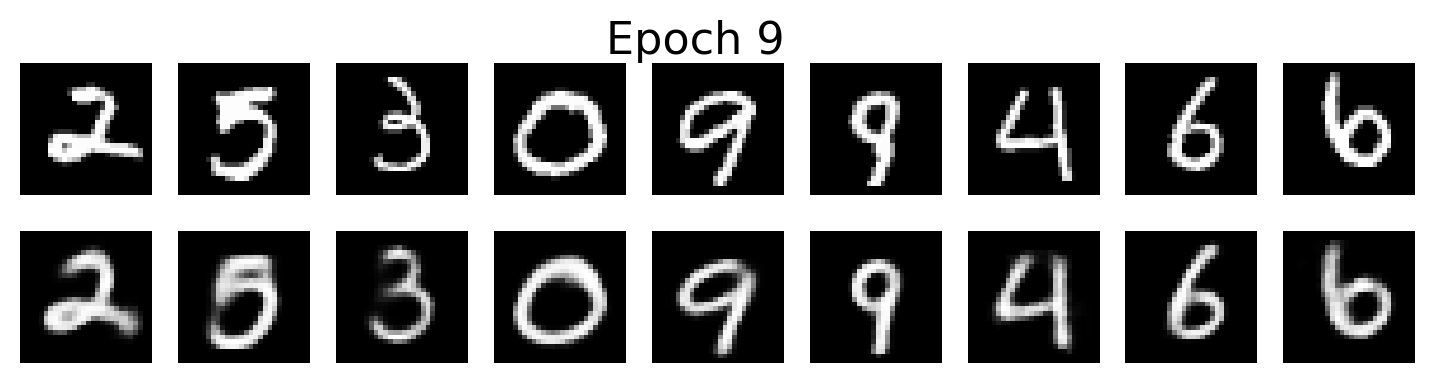

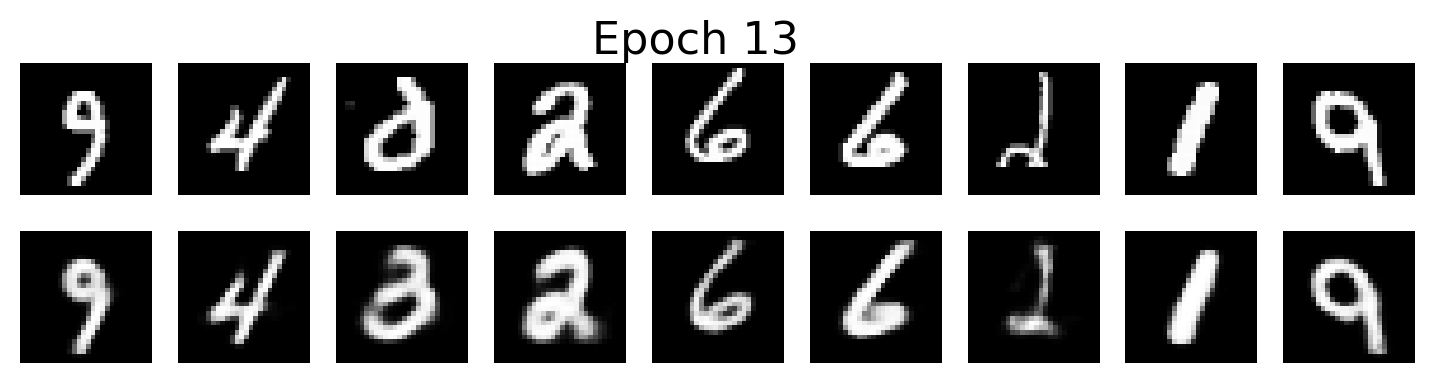

In [64]:
model = Autoencoder(30)
outputs = train_autoencoder(model, train_loader, num_epochs=13, lambda_l1=1e-7, weight_decay=1e-7)
visualize_reconstructions(outputs)

#### 2.5.4 Projected dimension = 50.

Epoch [1/13], Loss: 0.1083, Total Loss: 0.1118
Epoch [2/13], Loss: 0.1073, Total Loss: 0.1111
Epoch [3/13], Loss: 0.0965, Total Loss: 0.1005
Epoch [4/13], Loss: 0.0816, Total Loss: 0.0858
Epoch [5/13], Loss: 0.0999, Total Loss: 0.1043
Epoch [6/13], Loss: 0.0850, Total Loss: 0.0896
Epoch [7/13], Loss: 0.0665, Total Loss: 0.0713
Epoch [8/13], Loss: 0.0590, Total Loss: 0.0638
Epoch [9/13], Loss: 0.0731, Total Loss: 0.0780
Epoch [10/13], Loss: 0.0643, Total Loss: 0.0693
Epoch [11/13], Loss: 0.0658, Total Loss: 0.0710
Epoch [12/13], Loss: 0.0516, Total Loss: 0.0569
Epoch [13/13], Loss: 0.0624, Total Loss: 0.0677


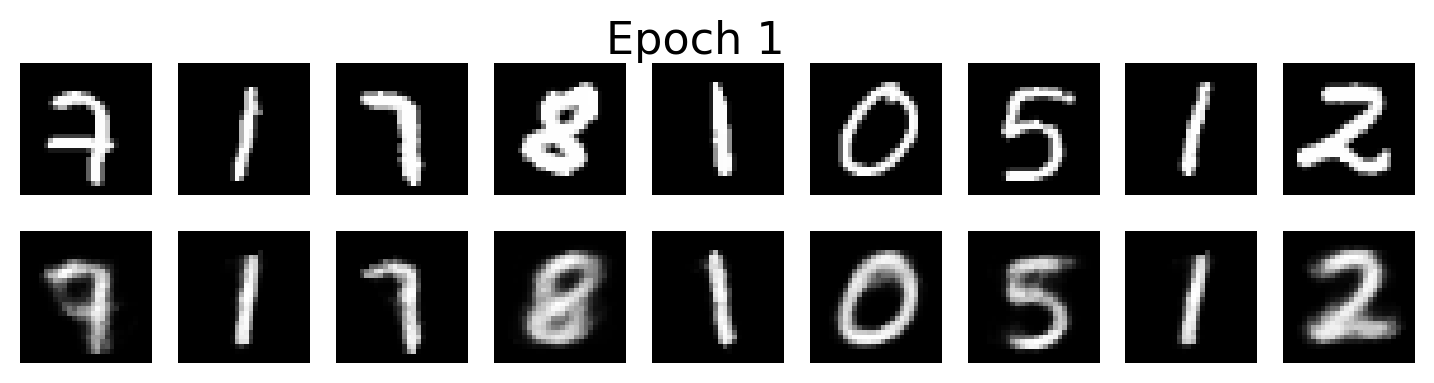

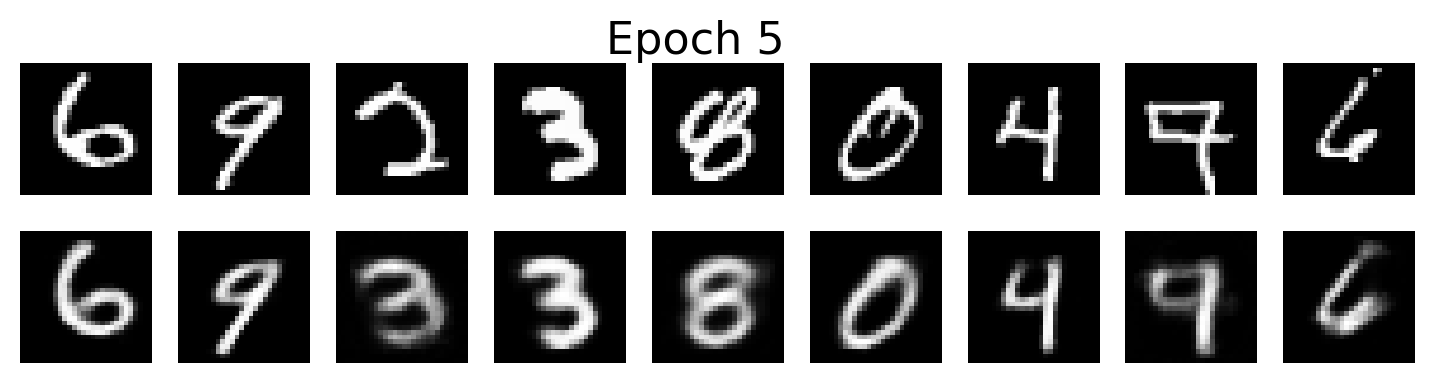

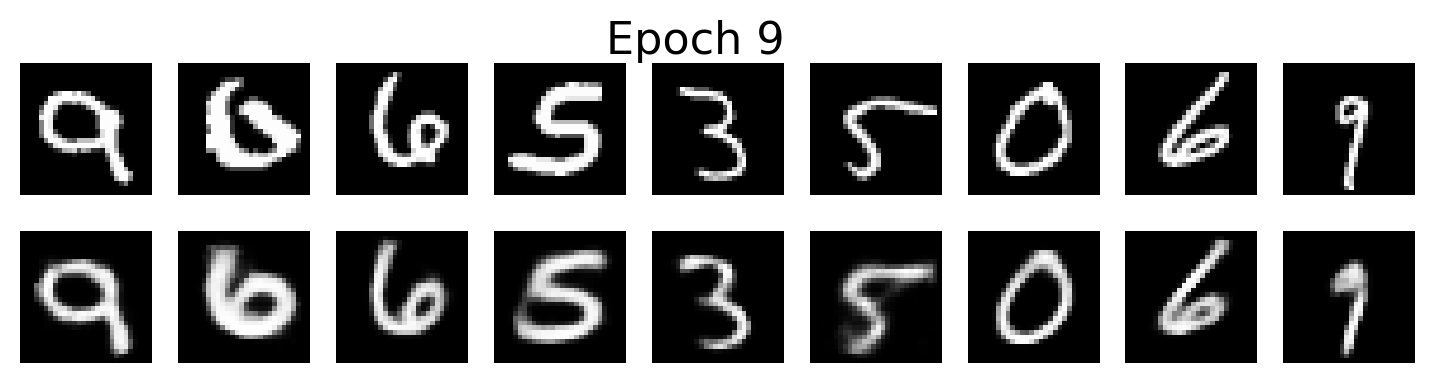

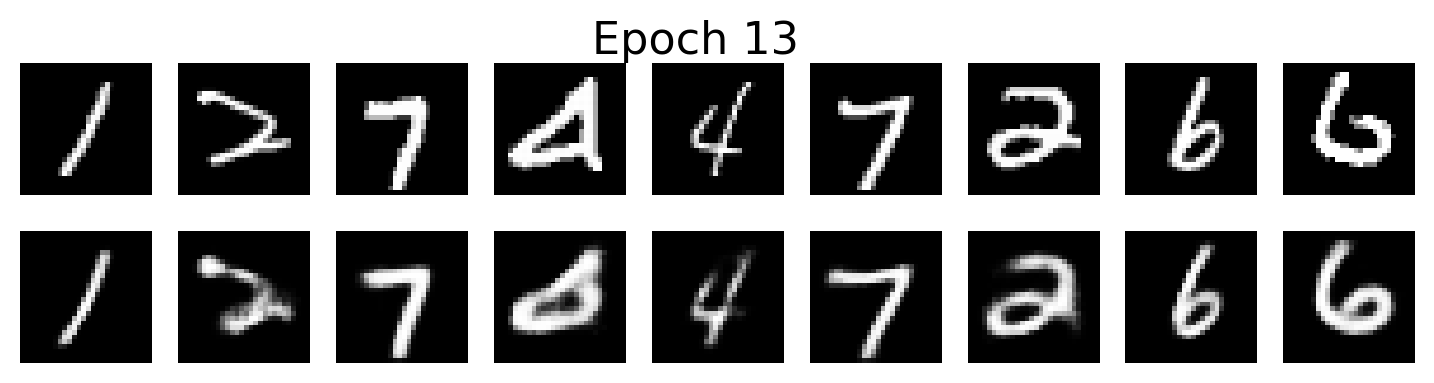

In [65]:
model = Autoencoder(50)
outputs = train_autoencoder(model, train_loader, num_epochs=13, lambda_l1=1e-7, weight_decay=1e-7)
visualize_reconstructions(outputs)

#### 2.5.5 Projected dimension = 100.

Epoch [1/13], Loss: 0.1290, Total Loss: 0.1324
Epoch [2/13], Loss: 0.1216, Total Loss: 0.1254
Epoch [3/13], Loss: 0.0860, Total Loss: 0.0899
Epoch [4/13], Loss: 0.0802, Total Loss: 0.0844
Epoch [5/13], Loss: 0.0807, Total Loss: 0.0850
Epoch [6/13], Loss: 0.0754, Total Loss: 0.0798
Epoch [7/13], Loss: 0.0631, Total Loss: 0.0677
Epoch [8/13], Loss: 0.0583, Total Loss: 0.0629
Epoch [9/13], Loss: 0.0625, Total Loss: 0.0673
Epoch [10/13], Loss: 0.0725, Total Loss: 0.0774
Epoch [11/13], Loss: 0.0611, Total Loss: 0.0660
Epoch [12/13], Loss: 0.0441, Total Loss: 0.0491
Epoch [13/13], Loss: 0.0526, Total Loss: 0.0577


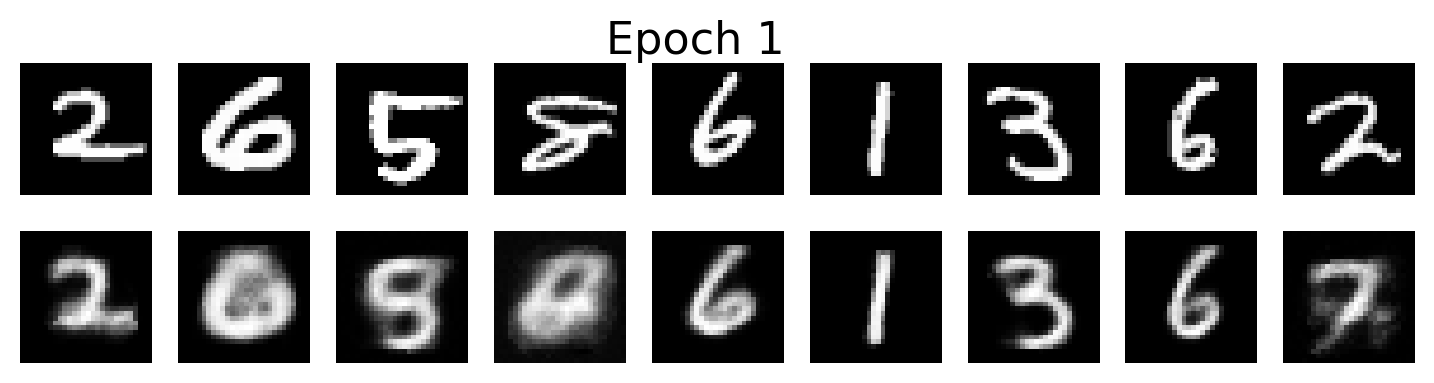

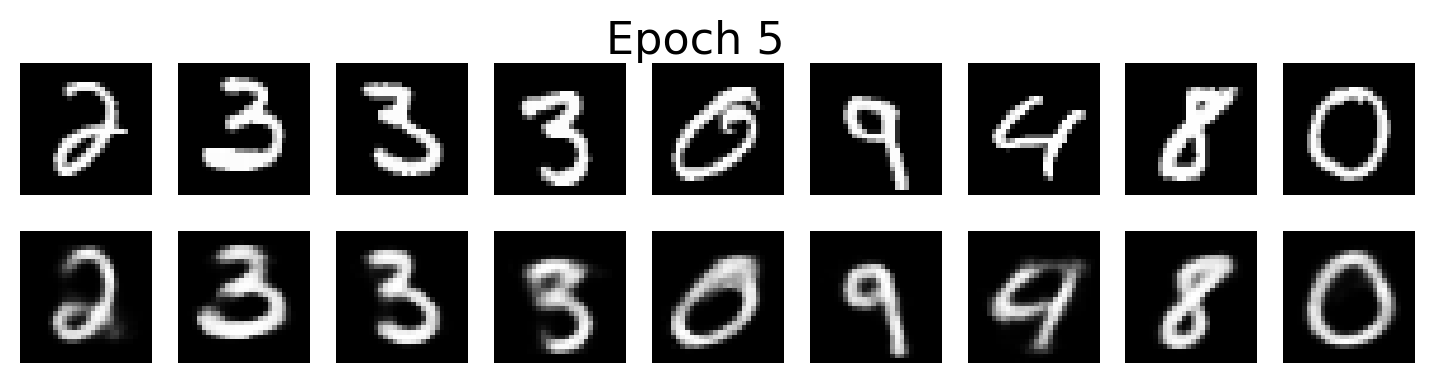

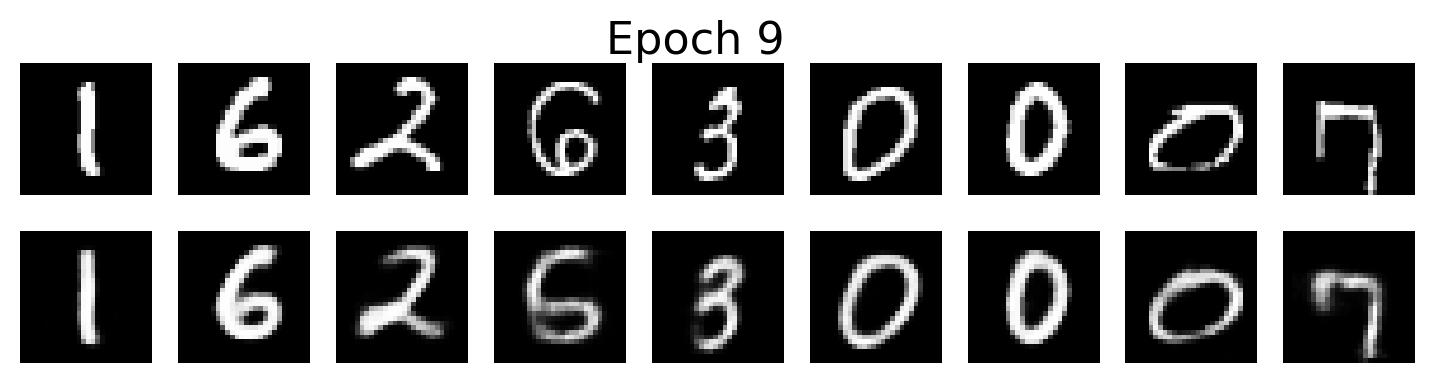

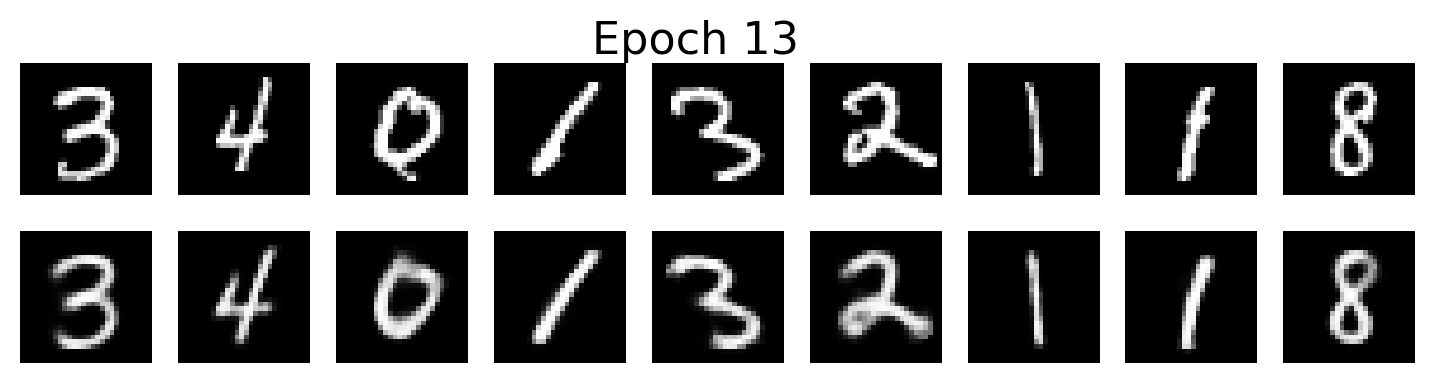

In [66]:
model = Autoencoder(100)
outputs = train_autoencoder(model, train_loader, num_epochs=13, lambda_l1=1e-7, weight_decay=1e-7)
visualize_reconstructions(outputs)

## 3. FMNIST

We are going to repeat exactly the steps of point 2. MNIST but for this other database, in which we find another type of images. You will not see so many clarifications in the process because they are the same steps as before.

### 3.1. Download FMINST

In [67]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

We check that our values are in [-1, 1], therefore, we will apply Tanh() in the decoder

In [26]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(-1.) tensor(1.)


### 3.2. 3-Layer Autoencoder

In [68]:
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim=3):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),          # First layer: input to 256
            nn.ReLU(),
            nn.Linear(256, 144),            # Second layer: 256 to 144
            nn.ReLU(),
            nn.Linear(144, encoding_dim)    # Third layer: 144 to encoding_dim
        ) 
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 144),   # First layer: encoding_dim to 144
            nn.ReLU(),
            nn.Linear(144, 256),            # Second layer: 144 to 256
            nn.ReLU(),
            nn.Linear(256, 28*28),          # Third layer: 256 to input dimensions
            nn.Tanh()                       # We can use nn.Sigmoid() if necessary.
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Example:
model = Autoencoder(15)
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=144, bias=True)
    (3): ReLU()
    (4): Linear(in_features=144, out_features=15, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=144, bias=True)
    (1): ReLU()
    (2): Linear(in_features=144, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Tanh()
  )
)


### 3.3. Training of an Autoencoder Model using PyTorch.

For this step we will use the same functions that we defined for the MNIST database

### 3.4. Results.

#### 3.4.1 Projected dimension = 15.

Epoch [1/10], Loss: 0.0685, Total Loss: 0.1977
Epoch [2/10], Loss: 0.0616, Total Loss: 0.1939
Epoch [3/10], Loss: 0.0558, Total Loss: 0.1897
Epoch [4/10], Loss: 0.0513, Total Loss: 0.1858
Epoch [5/10], Loss: 0.0438, Total Loss: 0.1789
Epoch [6/10], Loss: 0.0452, Total Loss: 0.1799
Epoch [7/10], Loss: 0.0367, Total Loss: 0.1718
Epoch [8/10], Loss: 0.0556, Total Loss: 0.1906
Epoch [9/10], Loss: 0.0437, Total Loss: 0.1787
Epoch [10/10], Loss: 0.0510, Total Loss: 0.1864


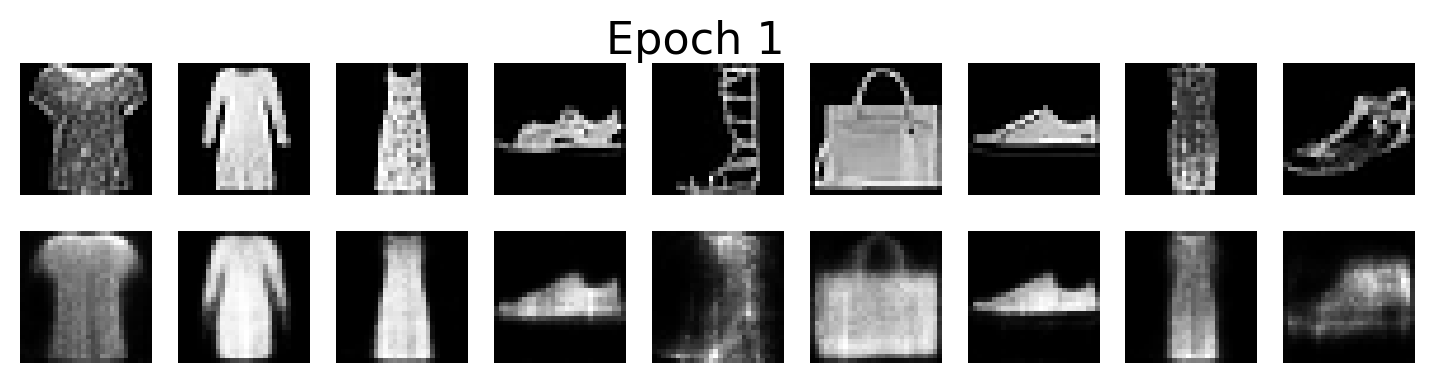

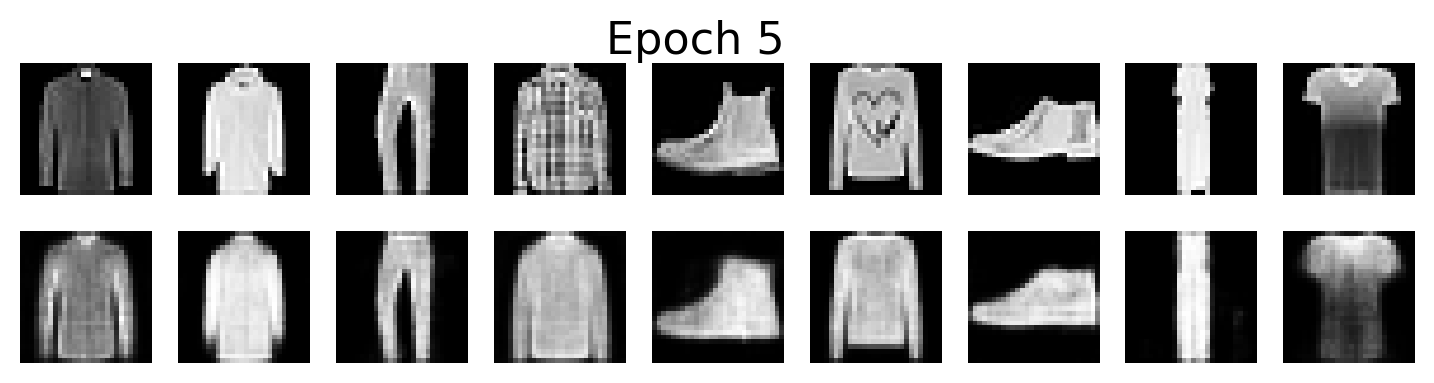

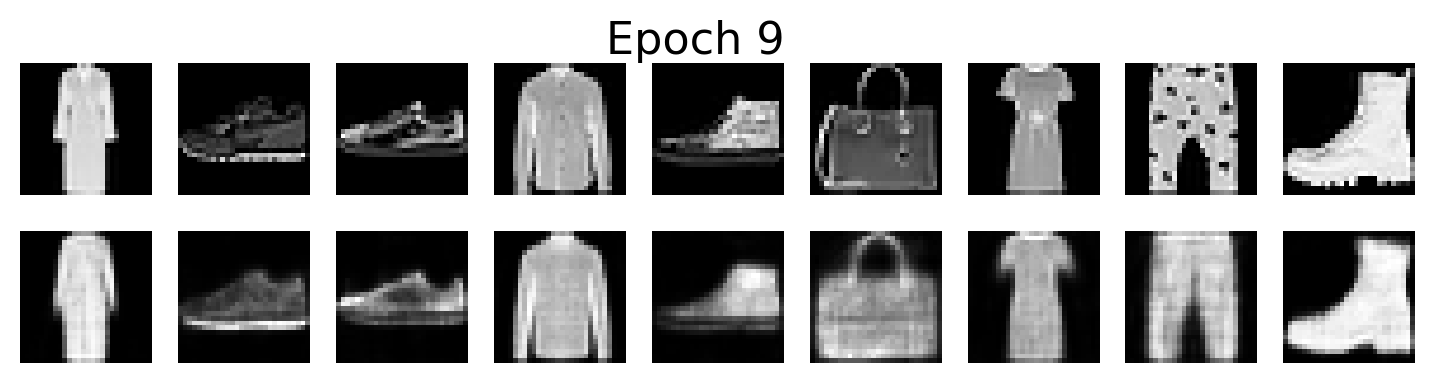

In [35]:
model = Autoencoder(15)
outputs = train_autoencoder(model, train_loader)
visualize_reconstructions(outputs)

#### 3.4.2 Projected dimension = 30.

Epoch [1/10], Loss: 0.0623, Total Loss: 0.1927
Epoch [2/10], Loss: 0.0515, Total Loss: 0.1852
Epoch [3/10], Loss: 0.0490, Total Loss: 0.1848
Epoch [4/10], Loss: 0.0461, Total Loss: 0.1827
Epoch [5/10], Loss: 0.0432, Total Loss: 0.1803
Epoch [6/10], Loss: 0.0412, Total Loss: 0.1788
Epoch [7/10], Loss: 0.0490, Total Loss: 0.1873
Epoch [8/10], Loss: 0.0479, Total Loss: 0.1858
Epoch [9/10], Loss: 0.0427, Total Loss: 0.1816
Epoch [10/10], Loss: 0.0406, Total Loss: 0.1794


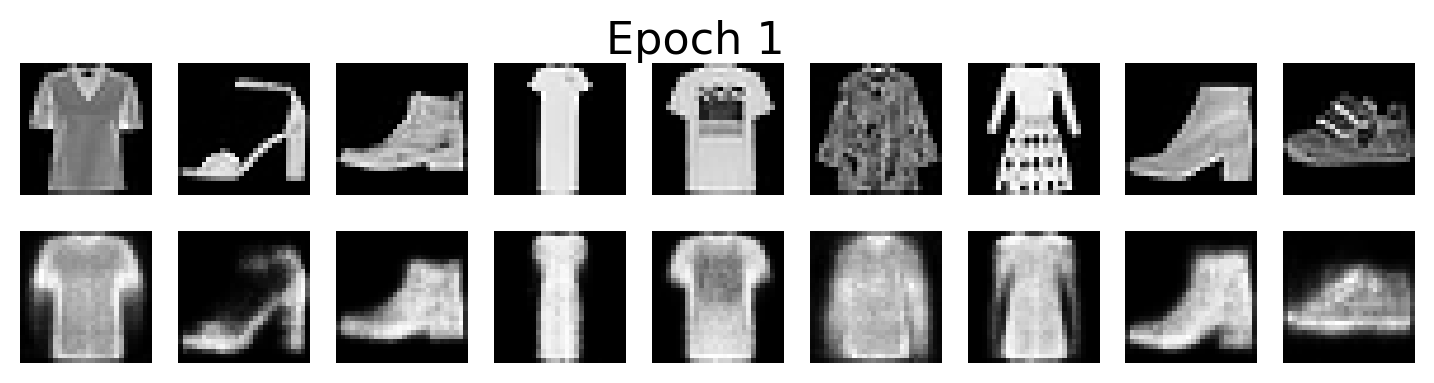

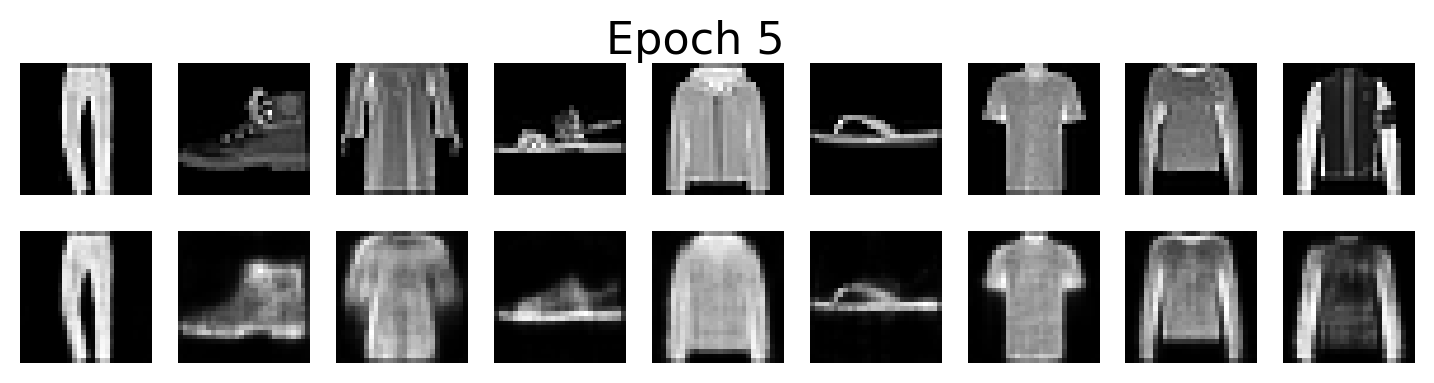

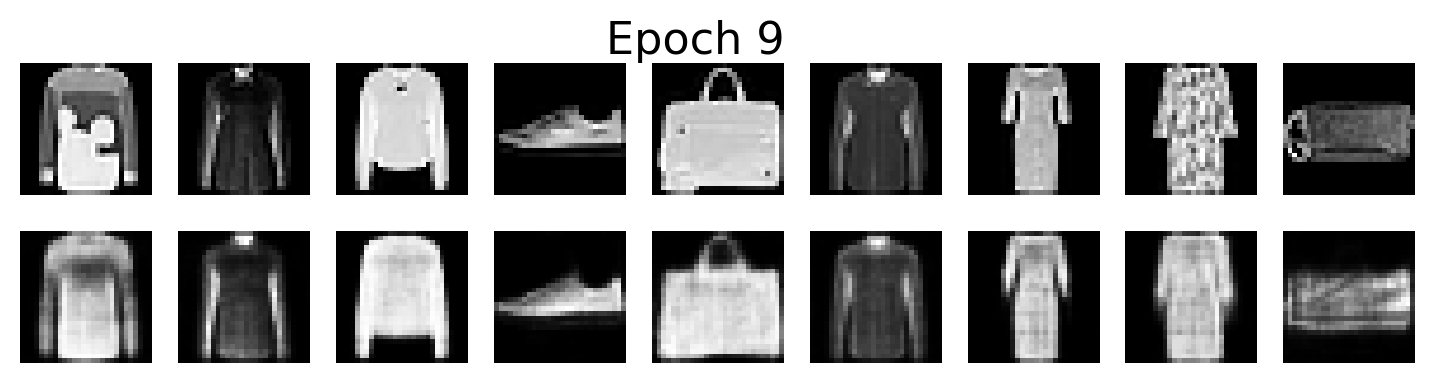

In [36]:
model = Autoencoder(30)
outputs = train_autoencoder(model, train_loader)
visualize_reconstructions(outputs)

#### 3.4.3 Projected dimension = 50.

Epoch [1/10], Loss: 0.0590, Total Loss: 0.1886
Epoch [2/10], Loss: 0.0464, Total Loss: 0.1794
Epoch [3/10], Loss: 0.0424, Total Loss: 0.1769
Epoch [4/10], Loss: 0.0442, Total Loss: 0.1801
Epoch [5/10], Loss: 0.0392, Total Loss: 0.1757
Epoch [6/10], Loss: 0.0341, Total Loss: 0.1720
Epoch [7/10], Loss: 0.0407, Total Loss: 0.1783
Epoch [8/10], Loss: 0.0428, Total Loss: 0.1812
Epoch [9/10], Loss: 0.0356, Total Loss: 0.1739
Epoch [10/10], Loss: 0.0465, Total Loss: 0.1856


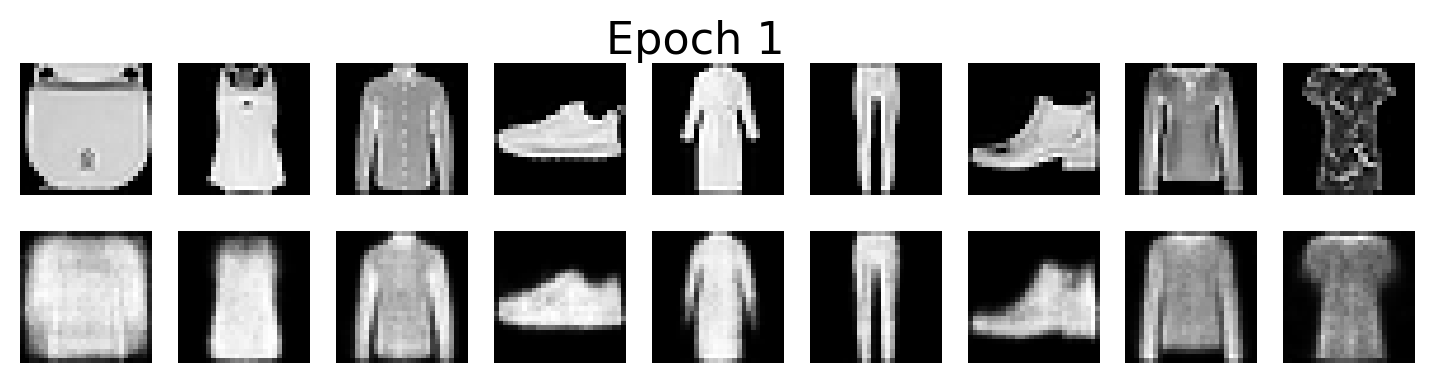

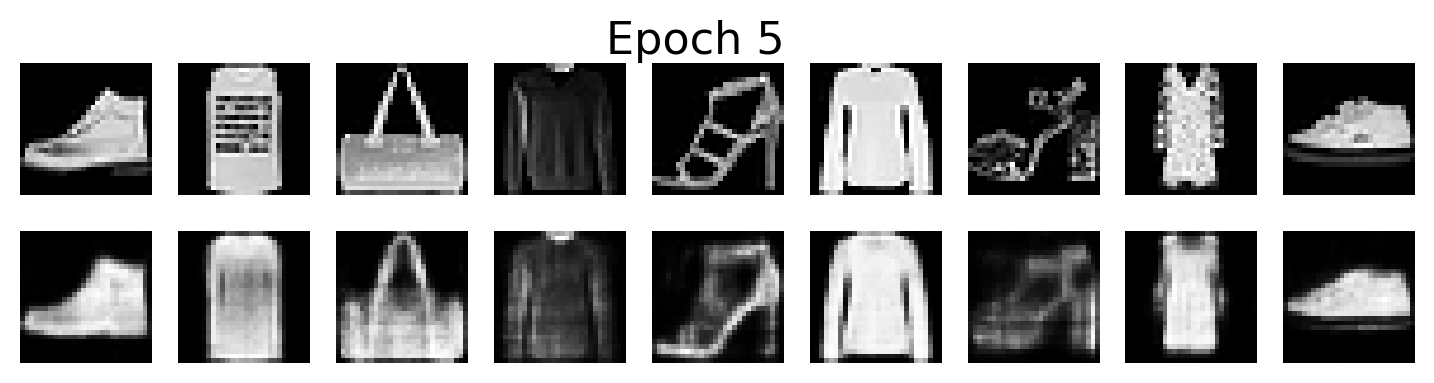

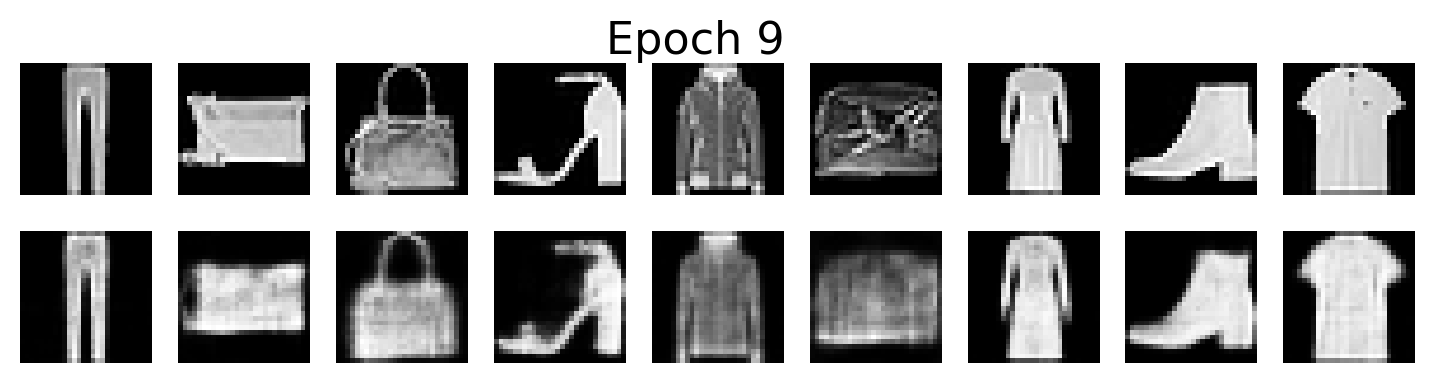

In [37]:
model = Autoencoder(50)
outputs = train_autoencoder(model, train_loader)
visualize_reconstructions(outputs)

#### 3.4.4 Projected dimension = 100.

Epoch [1/10], Loss: 0.0692, Total Loss: 0.1959
Epoch [2/10], Loss: 0.0543, Total Loss: 0.1832
Epoch [3/10], Loss: 0.0624, Total Loss: 0.1931
Epoch [4/10], Loss: 0.0446, Total Loss: 0.1770
Epoch [5/10], Loss: 0.0450, Total Loss: 0.1783
Epoch [6/10], Loss: 0.0367, Total Loss: 0.1707
Epoch [7/10], Loss: 0.0402, Total Loss: 0.1747
Epoch [8/10], Loss: 0.0385, Total Loss: 0.1744
Epoch [9/10], Loss: 0.0327, Total Loss: 0.1686
Epoch [10/10], Loss: 0.0419, Total Loss: 0.1795


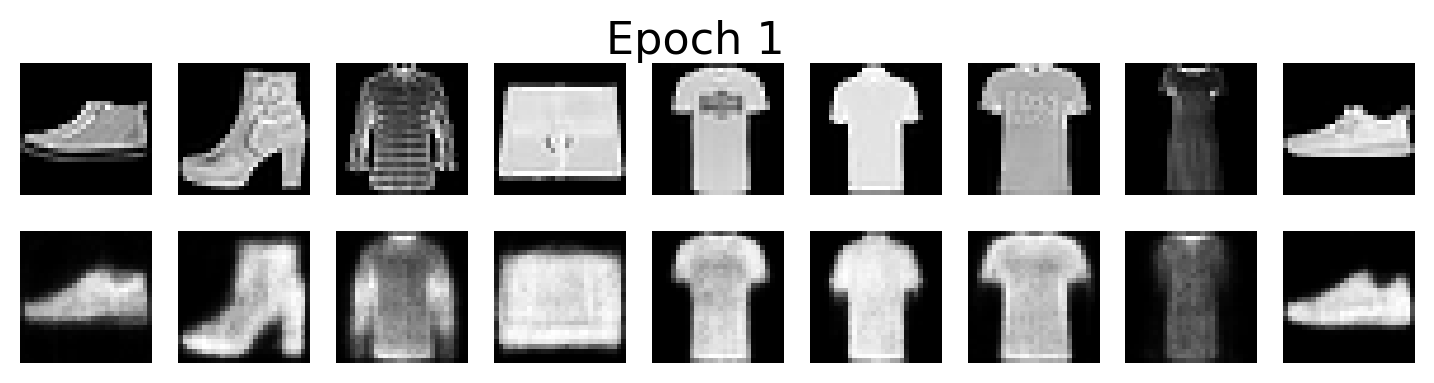

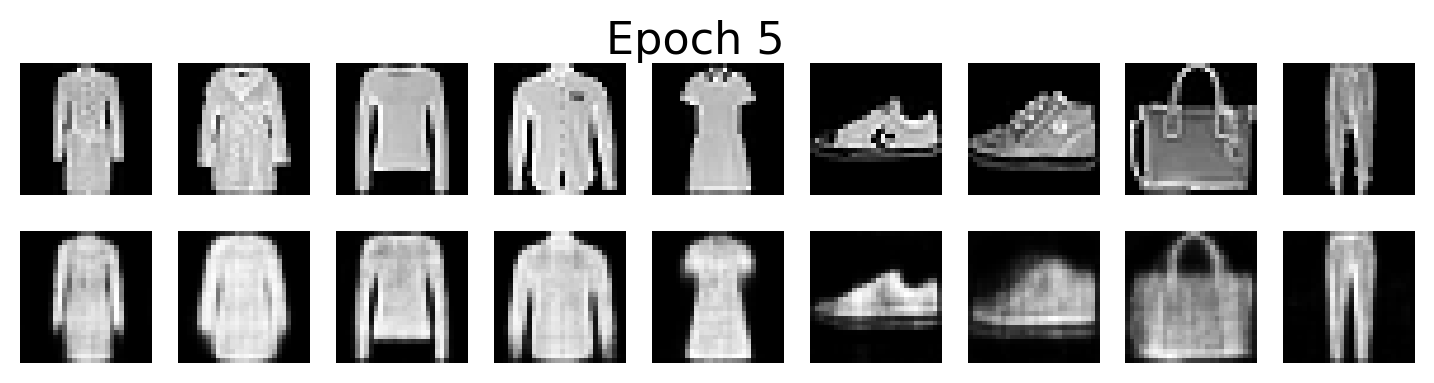

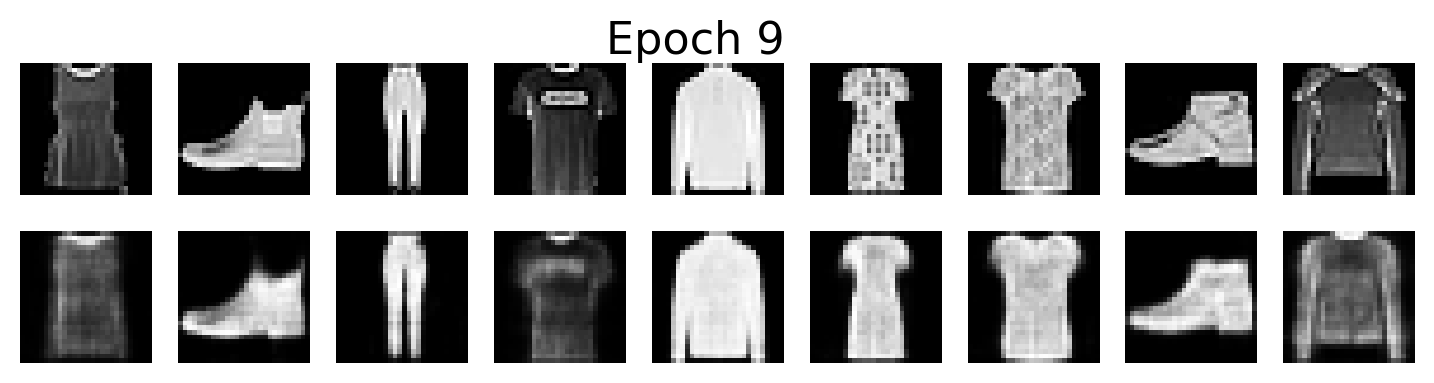

In [69]:
model = Autoencoder(100)
outputs = train_autoencoder(model, train_loader)
visualize_reconstructions(outputs)

### 2.5. 5-Layer Autoencoder

Rerun the data download code if necessary.

In [70]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [71]:
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim=3):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 640),           # First layer: input to 640
            nn.ReLU(),
            nn.Linear(640, 512),             # Second layer: 640 to 512
            nn.ReLU(),
            nn.Linear(512, 256),             # Third layer: 512 to 256
            nn.ReLU(),
            nn.Linear(256, 144),             # Fourth layer: 256 to 144
            nn.ReLU(),
            nn.Linear(144, encoding_dim)     # Fifth layer: 144 to encoding_dim (space latent)
        ) 
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 144),    # First layer: encoding_dim to 144
            nn.ReLU(),
            nn.Linear(144, 256),             # Second layer: 144 to 256
            nn.ReLU(),
            nn.Linear(256, 512),            # Third layer: 256 to 512
            nn.ReLU(),
            nn.Linear(512, 640),            # Fourth layer: 512 to 640
            nn.ReLU(),
            nn.Linear(640, 28*28),          # Fifth layer: 640 to input dimensions
            nn.Tanh()                       # We can use nn.Sigmoid() if necessary.
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Example usage:
model = Autoencoder(15)
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=640, bias=True)
    (1): ReLU()
    (2): Linear(in_features=640, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=144, bias=True)
    (7): ReLU()
    (8): Linear(in_features=144, out_features=15, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=144, bias=True)
    (1): ReLU()
    (2): Linear(in_features=144, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=640, bias=True)
    (7): ReLU()
    (8): Linear(in_features=640, out_features=784, bias=True)
    (9): Tanh()
  )
)


#### 3.5.1. Train the 5-Layer Autoencoder and Results

In [72]:
criterion = nn.MSELoss()

#### 3.5.2 Projected dimension = 15.

Epoch [1/13], Loss: 0.0796, Total Loss: 0.0837
Epoch [2/13], Loss: 0.0639, Total Loss: 0.0684
Epoch [3/13], Loss: 0.0532, Total Loss: 0.0581
Epoch [4/13], Loss: 0.0618, Total Loss: 0.0671
Epoch [5/13], Loss: 0.0610, Total Loss: 0.0665
Epoch [6/13], Loss: 0.0600, Total Loss: 0.0658
Epoch [7/13], Loss: 0.0683, Total Loss: 0.0743
Epoch [8/13], Loss: 0.0513, Total Loss: 0.0574
Epoch [9/13], Loss: 0.0461, Total Loss: 0.0524
Epoch [10/13], Loss: 0.0434, Total Loss: 0.0497
Epoch [11/13], Loss: 0.0605, Total Loss: 0.0670
Epoch [12/13], Loss: 0.0534, Total Loss: 0.0600
Epoch [13/13], Loss: 0.0564, Total Loss: 0.0631


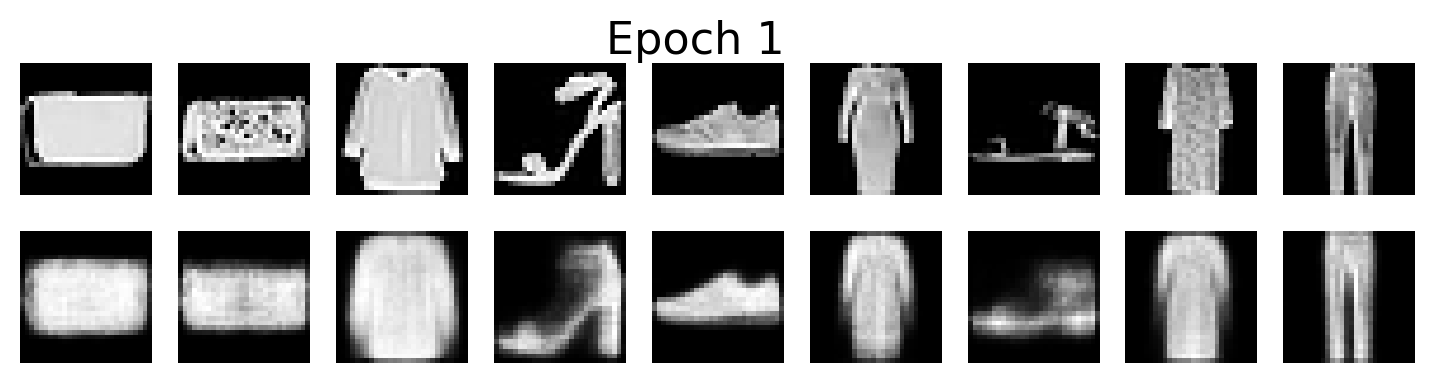

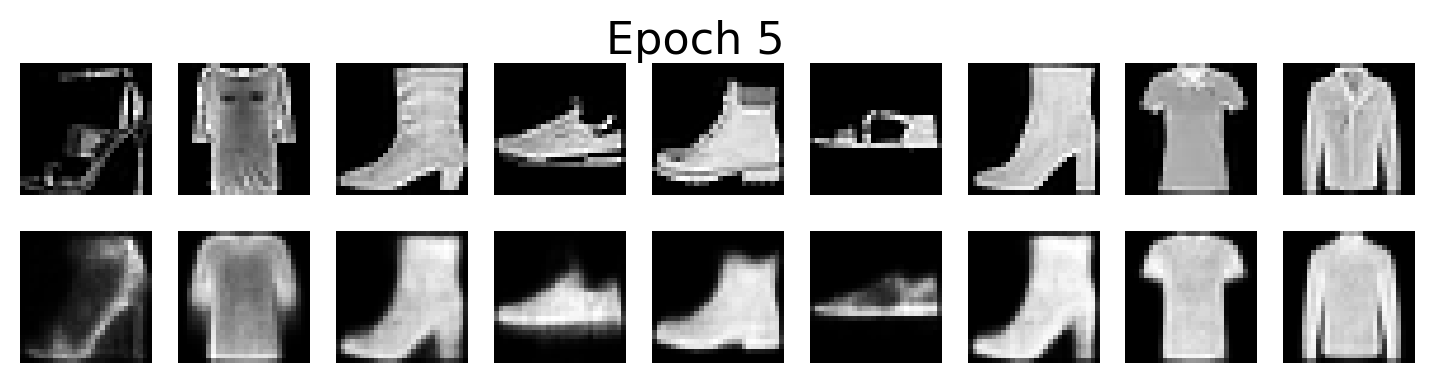

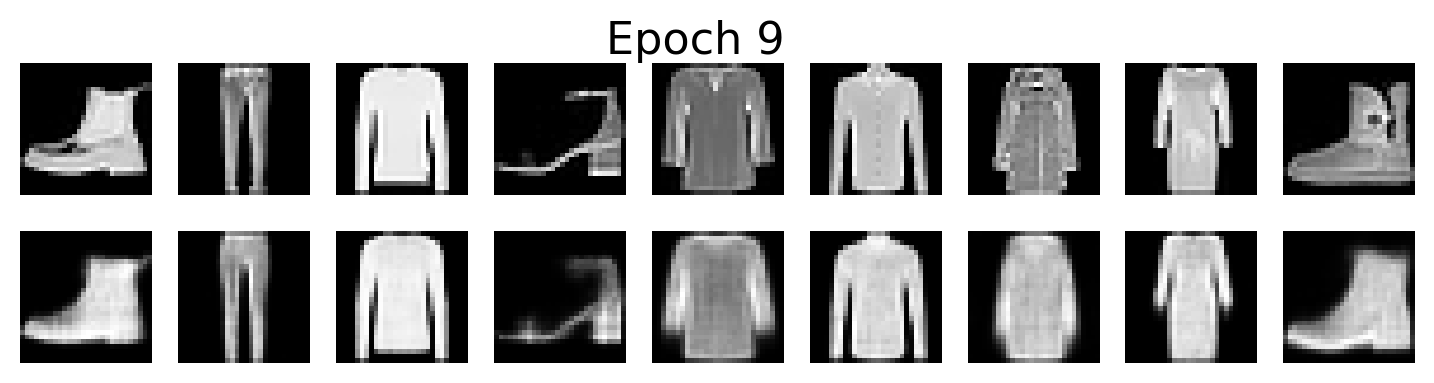

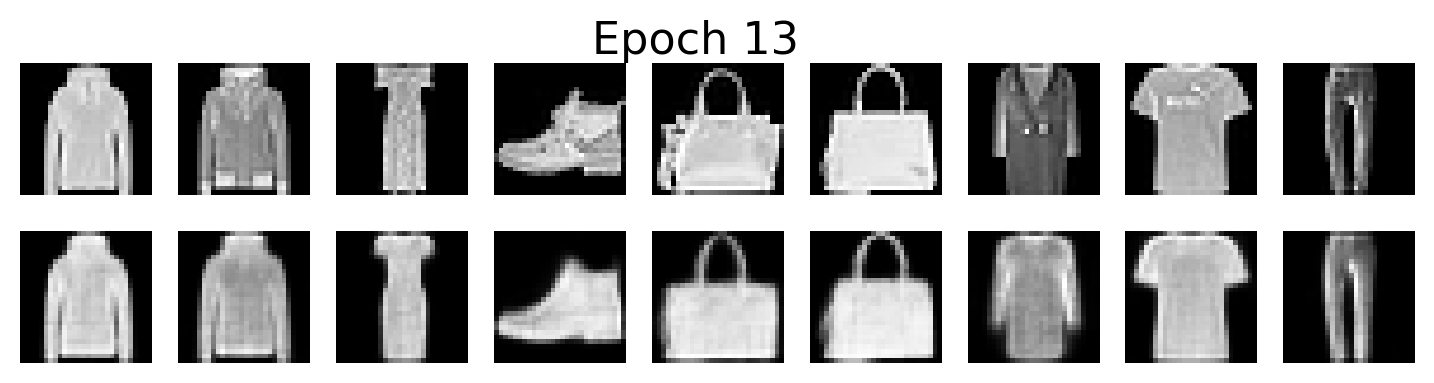

In [73]:
model = Autoencoder(15)
outputs = train_autoencoder(model, train_loader, num_epochs=13, lambda_l1=1e-7, weight_decay=1e-7)
visualize_reconstructions(outputs)

#### 3.5.3 Projected dimension = 30.

Epoch [1/13], Loss: 0.0864, Total Loss: 0.0905
Epoch [2/13], Loss: 0.0790, Total Loss: 0.0835
Epoch [3/13], Loss: 0.0653, Total Loss: 0.0701
Epoch [4/13], Loss: 0.0614, Total Loss: 0.0666
Epoch [5/13], Loss: 0.0735, Total Loss: 0.0790
Epoch [6/13], Loss: 0.0602, Total Loss: 0.0660
Epoch [7/13], Loss: 0.0569, Total Loss: 0.0629
Epoch [8/13], Loss: 0.0546, Total Loss: 0.0608
Epoch [9/13], Loss: 0.0651, Total Loss: 0.0714
Epoch [10/13], Loss: 0.0576, Total Loss: 0.0641
Epoch [11/13], Loss: 0.0581, Total Loss: 0.0646
Epoch [12/13], Loss: 0.0561, Total Loss: 0.0628
Epoch [13/13], Loss: 0.0415, Total Loss: 0.0483


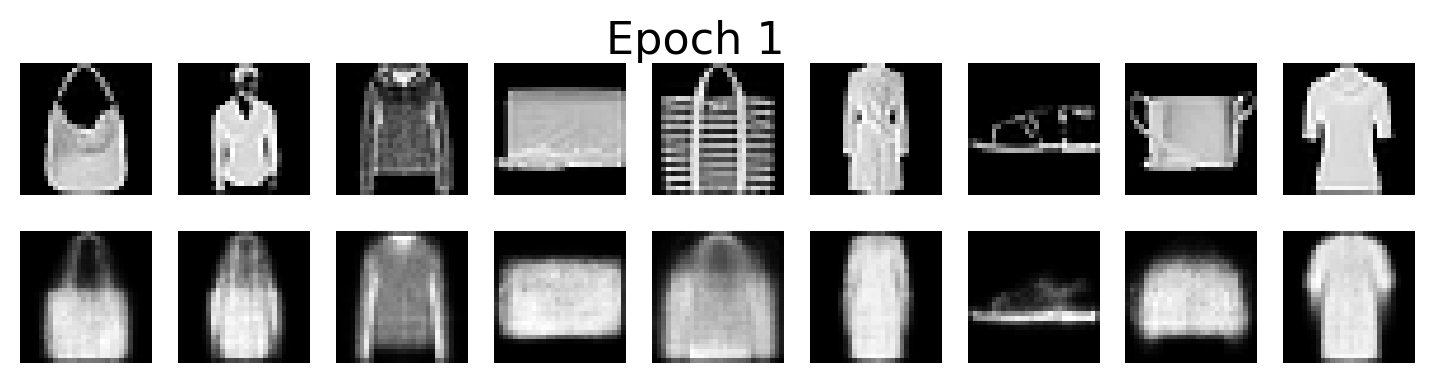

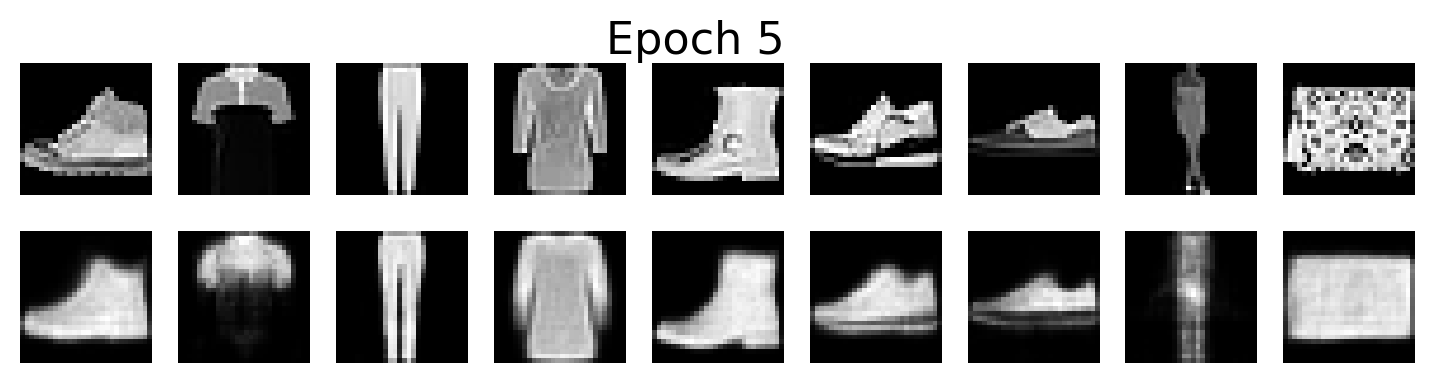

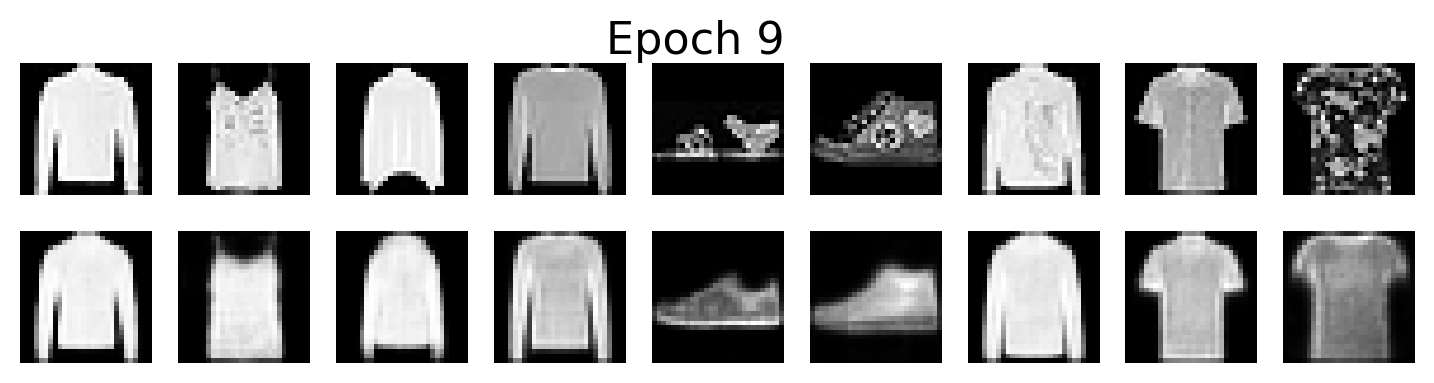

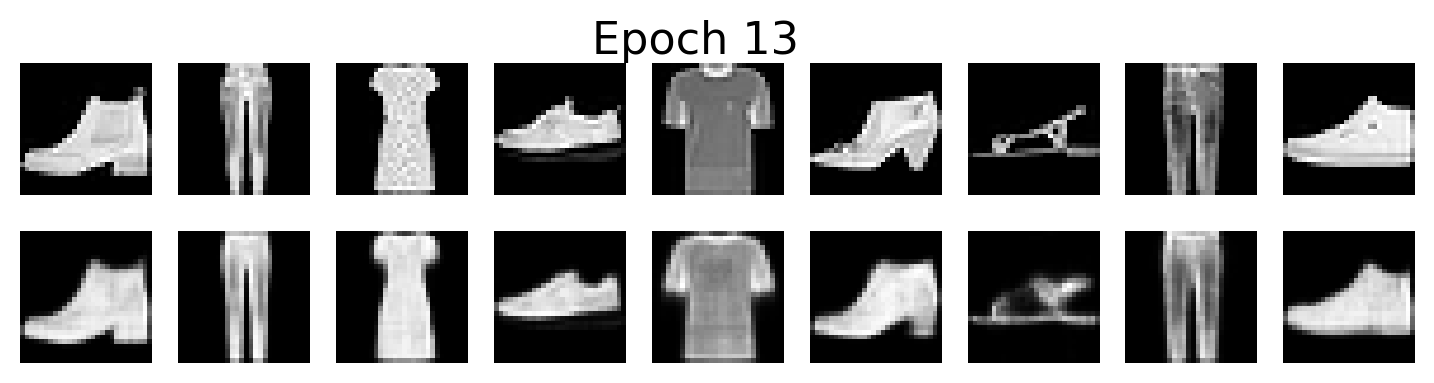

In [74]:
model = Autoencoder(30)
outputs = train_autoencoder(model, train_loader, num_epochs=13, lambda_l1=1e-7, weight_decay=1e-7)
visualize_reconstructions(outputs)

#### 3.5.4 Projected dimension = 50.

Epoch [1/13], Loss: 0.0905, Total Loss: 0.0946
Epoch [2/13], Loss: 0.0652, Total Loss: 0.0696
Epoch [3/13], Loss: 0.0761, Total Loss: 0.0808
Epoch [4/13], Loss: 0.0675, Total Loss: 0.0725
Epoch [5/13], Loss: 0.0566, Total Loss: 0.0619
Epoch [6/13], Loss: 0.0646, Total Loss: 0.0701
Epoch [7/13], Loss: 0.0540, Total Loss: 0.0596
Epoch [8/13], Loss: 0.0389, Total Loss: 0.0447
Epoch [9/13], Loss: 0.0483, Total Loss: 0.0542
Epoch [10/13], Loss: 0.0459, Total Loss: 0.0519
Epoch [11/13], Loss: 0.0489, Total Loss: 0.0550
Epoch [12/13], Loss: 0.0466, Total Loss: 0.0528
Epoch [13/13], Loss: 0.0437, Total Loss: 0.0501


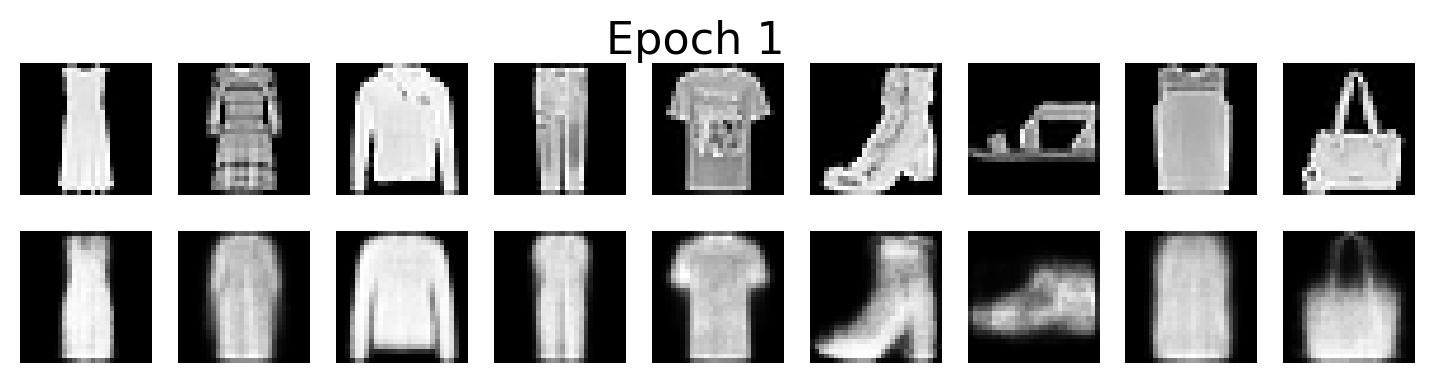

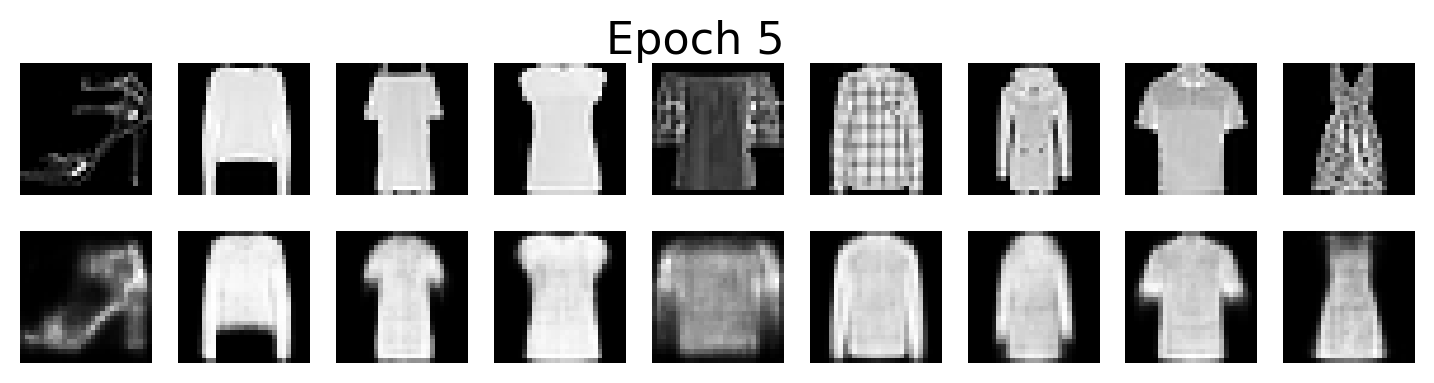

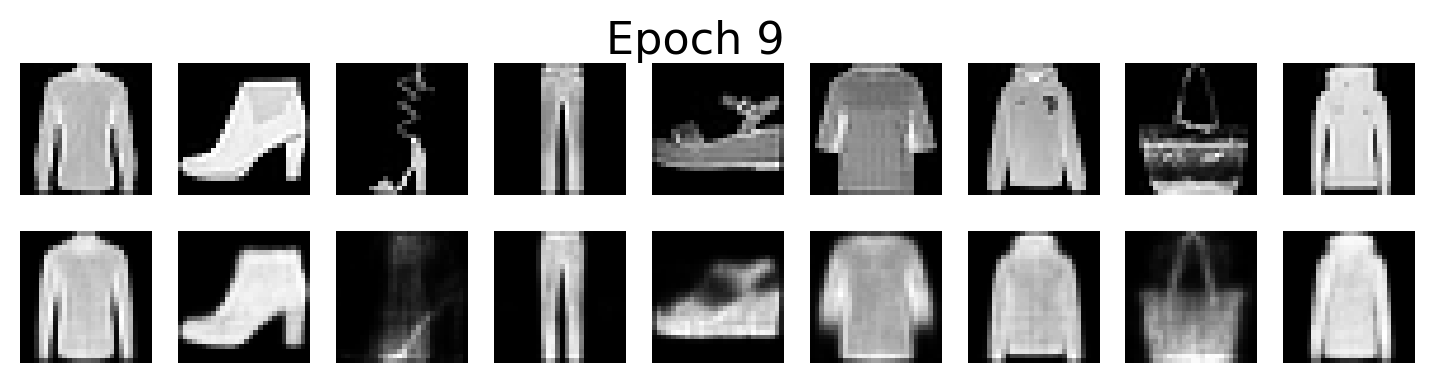

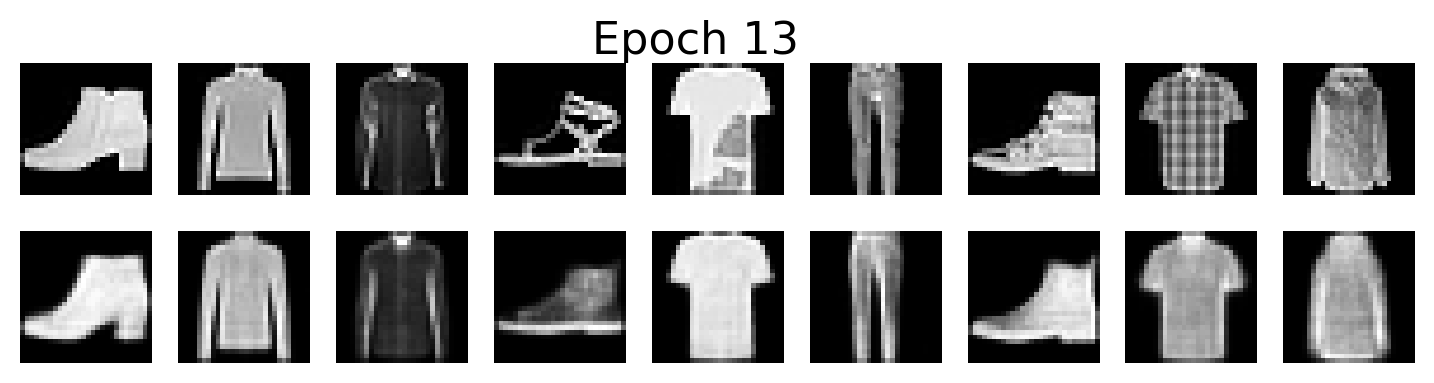

In [75]:
model = Autoencoder(50)
outputs = train_autoencoder(model, train_loader, num_epochs=13, lambda_l1=1e-7, weight_decay=1e-7)
visualize_reconstructions(outputs)

#### 3.5.5 Projected dimension = 100.

Epoch [1/13], Loss: 0.0899, Total Loss: 0.0941
Epoch [2/13], Loss: 0.0867, Total Loss: 0.0913
Epoch [3/13], Loss: 0.0669, Total Loss: 0.0718
Epoch [4/13], Loss: 0.0611, Total Loss: 0.0663
Epoch [5/13], Loss: 0.0667, Total Loss: 0.0722
Epoch [6/13], Loss: 0.0571, Total Loss: 0.0628
Epoch [7/13], Loss: 0.0670, Total Loss: 0.0729
Epoch [8/13], Loss: 0.0544, Total Loss: 0.0605
Epoch [9/13], Loss: 0.0490, Total Loss: 0.0553
Epoch [10/13], Loss: 0.0656, Total Loss: 0.0719
Epoch [11/13], Loss: 0.0545, Total Loss: 0.0610
Epoch [12/13], Loss: 0.0560, Total Loss: 0.0625
Epoch [13/13], Loss: 0.0503, Total Loss: 0.0570


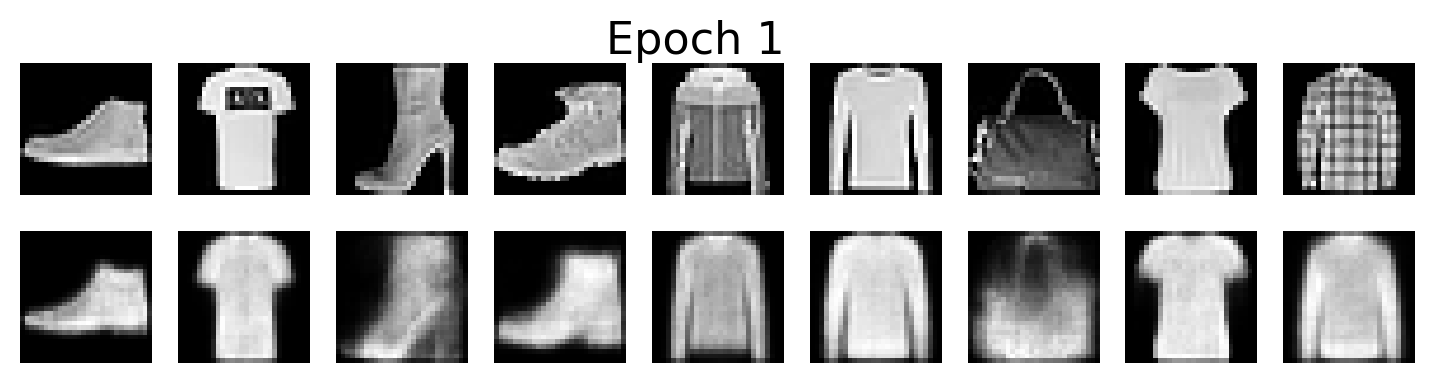

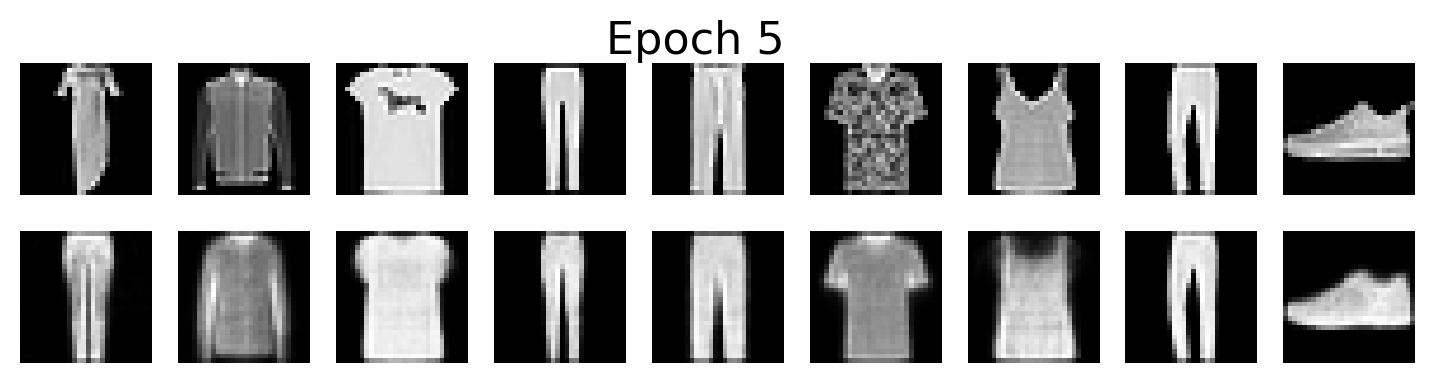

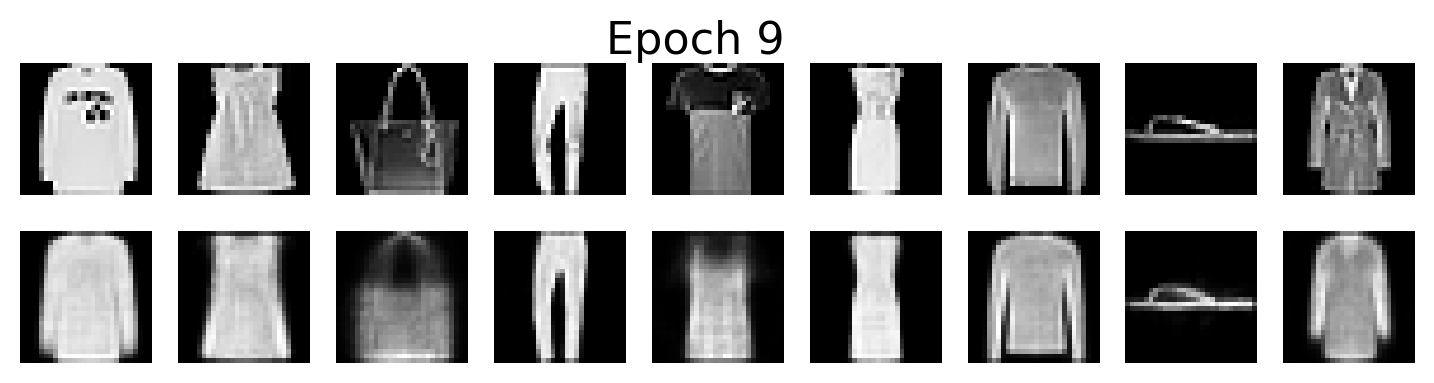

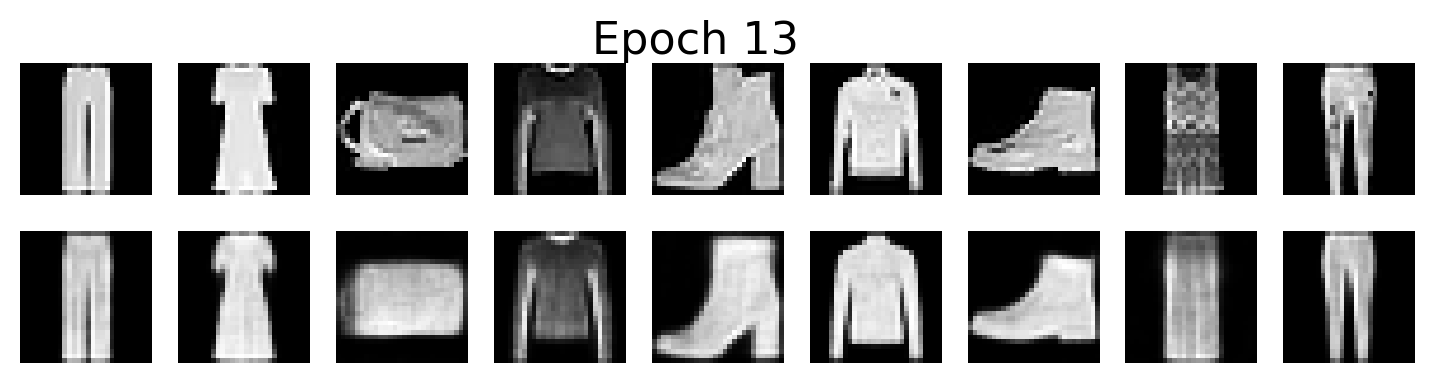

In [76]:
model = Autoencoder(100)
outputs = train_autoencoder(model, train_loader, num_epochs=13, lambda_l1=1e-7, weight_decay=1e-7)
visualize_reconstructions(outputs)

## 4. Denoising Autoencoder

Since we have already seen the differences between 3-layer autoencoders and 5-layer autoencoders, to apply the denoising autoencoder we have decided to opt for the 3-layer autoencoder for a matter of execution time. And we will show the results for the images obtained from both databases.

As with the projected dimensions, we have chosen to represent the largest and smallest to see the differences.

### 4.1 MNIST

Rerun the data download code if necessary.

In [50]:
# transform = transforms.ToTensor() # -> Values between 0 and 1 Sigmoid() in the decoder.

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ]) # -> Values between -1 and 1 Tanh() in the decoder.

# Download and load the training  data
train_set = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

# Download and load the test data
test_set = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

In [51]:
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim=3):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),          # First layer: input to 256
            nn.ReLU(),
            nn.Linear(256, 144),            # Second layer: 256 to 144
            nn.ReLU(),
            nn.Linear(144, encoding_dim)    # Third layer: 144 to encoding_dim
        ) 
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 144),   # First layer: encoding_dim to 144
            nn.ReLU(),
            nn.Linear(144, 256),            # Second layer: 144 to 256
            nn.ReLU(),
            nn.Linear(256, 28*28),          # Third layer: 256 to input dimensions
            nn.Tanh()                       # We can use nn.Sigmoid() if necessary.
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Example:
model = Autoencoder(15)
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=144, bias=True)
    (3): ReLU()
    (4): Linear(in_features=144, out_features=15, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=144, bias=True)
    (1): ReLU()
    (2): Linear(in_features=144, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Tanh()
  )
)


This function is used to simulate images corrupted by noise in the training process of a denoising autoencoder. By adding noise to the input images and then training the model to reconstruct the original clean images, the model learns to remove noise from the images. This improves its generalizability and usefulness.

In [40]:
def add_gaussian_noise(images, mean=0.0, std=1.0):
    noise = torch.randn_like(images) * std + mean # Generates Gaussian noise with the specified mean and std.
    noisy_images = images + noise # Adds noise to the original images.
    return torch.clamp(noisy_images, -1.0, 1.0) # Ensures that the values of the noisy images are in the range [-1, 1].


The calculate_psnr function is used to evaluate the quality of reconstructed images compared to the original images. The PSNR is a metric commonly used in signal and image processing to measure the reconstruction quality or effectiveness of denoising algorithms. A higher PSNR indicates better reconstruction quality.

In [41]:
def calculate_psnr(target, reconstructed, max_pixel=1.0):
    mse = torch.mean((target - reconstructed) ** 2) # Calculates the mean squared error (MSE) between target and reconstruction.
    max_pixel_tensor = torch.tensor(max_pixel, device=target.device, dtype=target.dtype) # Converts max_pixel to a tensor.
    psnr = 20 * torch.log10(max_pixel_tensor) - 10 * torch.log10(mse) # Calculates the PSNR based on the MSE.
    return psnr 


Training function, slightly different from the previous one for a denoising autoencoder. Training function, slightly different from the previous one for a denoising autoencoder. Noise must be added to the images and PSNR must be calculated.

In [42]:
def train_denoising_autoencoder(model, train_loader, criterion, num_epochs=10, lambda_l1=1e-5, std_dev_noise=0.5):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)  # L2 regularization
    outputs = []

    for epoch in range(num_epochs):
        for (img, _) in train_loader:
            noisy_img = add_gaussian_noise(img, std=std_dev_noise)
            img, noisy_img = img.reshape(-1, 28*28), noisy_img.reshape(-1, 28*28)

            recon = model(noisy_img)
            loss = criterion(recon, img)  # Use original clean images as a target
            
            # Calculate the L1 penalty
            l1_penalty = torch.tensor(0.).to(img.device)
            for param in model.parameters():
                l1_penalty += torch.sum(torch.abs(param))
            total_loss = loss + lambda_l1 * l1_penalty

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

        # PSNR calculation for the last batch processed
        psnr_value = calculate_psnr(img, recon)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Total Loss: {total_loss.item():.4f}, PSNR: {psnr_value:.2f}')

        # saves images for viewing
        outputs.append((noisy_img.cpu(), img.cpu(), recon.cpu()))

    return outputs

The visaulization of the images also changes a little bit because we want to represent the images with noise.

In [43]:
def visualize_denoising_reconstructions(outputs, interval=4):
    for k in range(0, len(outputs), interval):
        plt.figure(figsize=(9, 3))  # Adjust the size to accommodate three rows of images.
        plt.gray()
        
        # imgs contains the original images.
        imgs = outputs[k][1].detach().numpy()
        # noisy_imgs contains images with noise.
        noisy_imgs = outputs[k][0].detach().numpy()  
        # recon contains the reconstructed images.
        recon = outputs[k][2].detach().numpy()

        plt.suptitle(f'Epoch {k+1}', fontsize=16)

        # View the original images.
        for i, item in enumerate(imgs):
            if i >= 9: break
            plt.subplot(3, 9, i+1)  # Adjust to have three rows of images.
            item = item.reshape(-1, 28, 28)
            plt.imshow(item[0])
            plt.axis('off')
                
        # Display images with noise
        for i, item in enumerate(noisy_imgs):
            if i >= 9: break
            plt.subplot(3, 9, 9+i+1)  # The second row for images with noise.
            item = item.reshape(-1, 28, 28)
            plt.imshow(item[0])
            plt.axis('off')
        
        # Visualize the reconstructed images.
        for i, item in enumerate(recon):
            if i >= 9: break
            plt.subplot(3, 9, 18+i+1)  # The third row for reconstructed images.
            item = item.reshape(-1, 28, 28)
            plt.imshow(item[0])
            plt.axis('off')

In [44]:
criterion = nn.MSELoss()

Epoch [1/10], Loss: 0.1265, Total Loss: 0.1556, PSNR: 8.98
Epoch [2/10], Loss: 0.0970, Total Loss: 0.1222, PSNR: 10.13
Epoch [3/10], Loss: 0.1040, Total Loss: 0.1278, PSNR: 9.83
Epoch [4/10], Loss: 0.0928, Total Loss: 0.1159, PSNR: 10.33
Epoch [5/10], Loss: 0.0945, Total Loss: 0.1174, PSNR: 10.25
Epoch [6/10], Loss: 0.0817, Total Loss: 0.1044, PSNR: 10.88
Epoch [7/10], Loss: 0.0946, Total Loss: 0.1172, PSNR: 10.24
Epoch [8/10], Loss: 0.0872, Total Loss: 0.1096, PSNR: 10.59
Epoch [9/10], Loss: 0.0758, Total Loss: 0.0982, PSNR: 11.20
Epoch [10/10], Loss: 0.0808, Total Loss: 0.1034, PSNR: 10.93


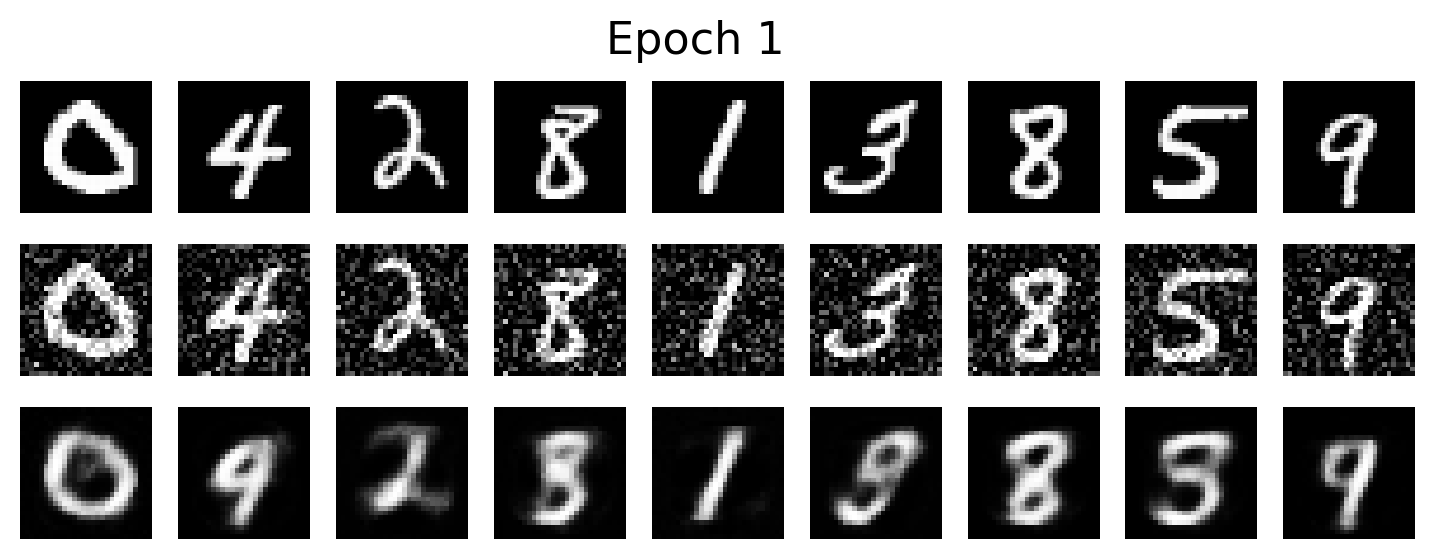

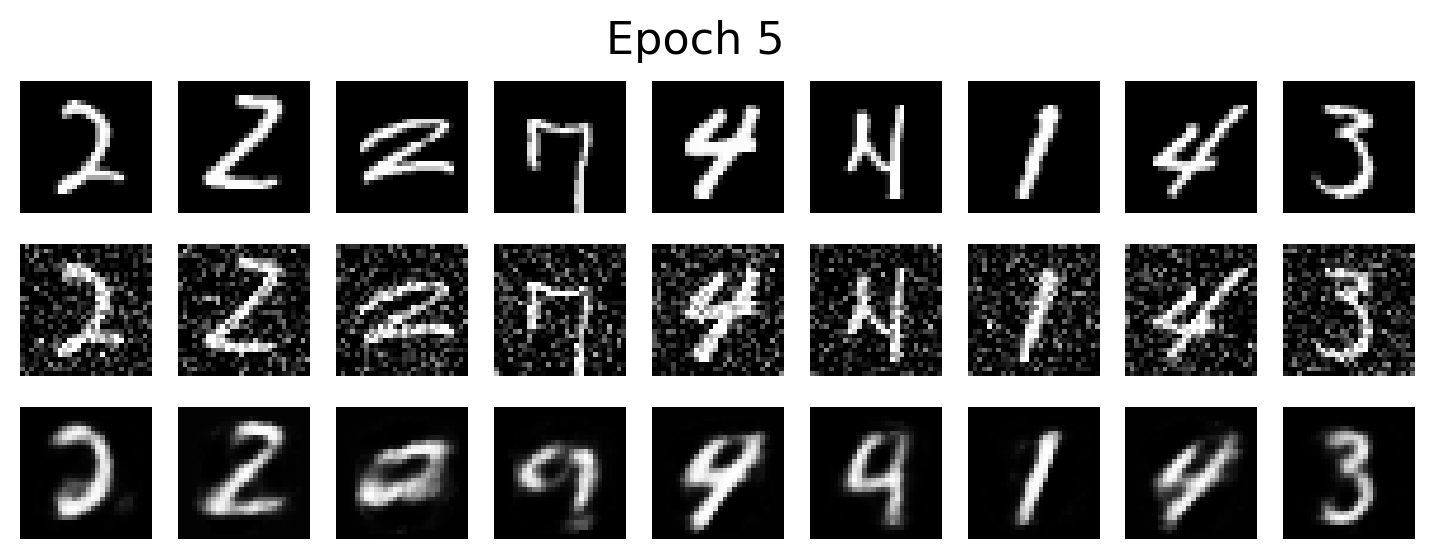

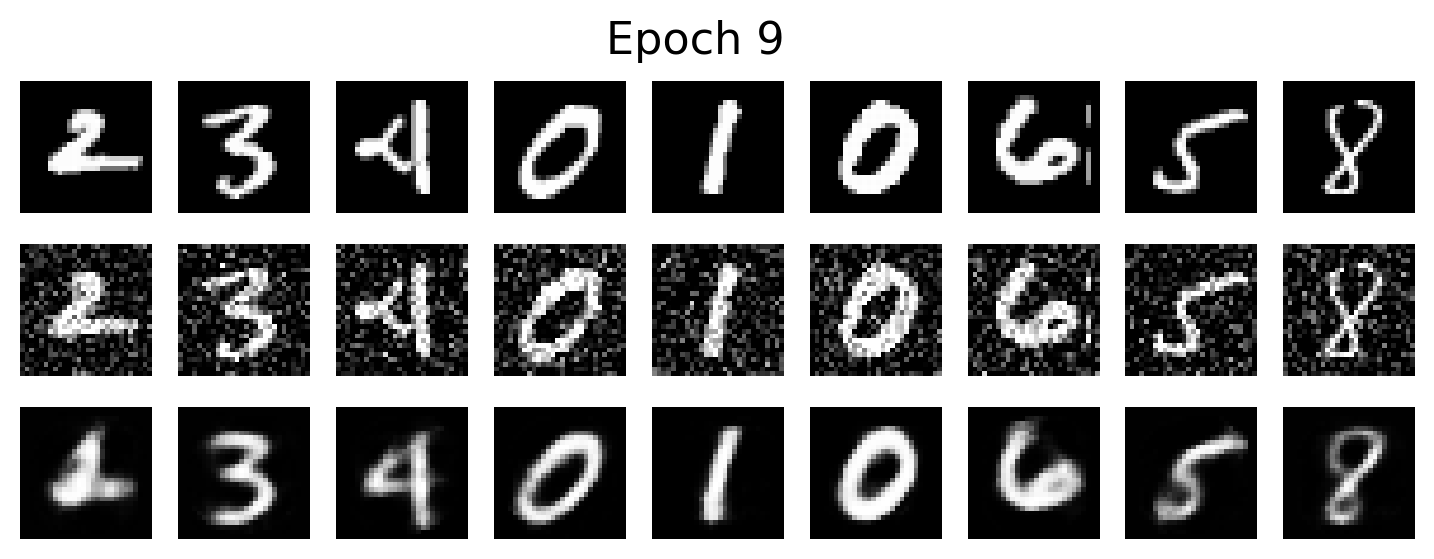

In [45]:
model = Autoencoder(15)
outputs = train_denoising_autoencoder(model, train_loader, criterion)
visualize_denoising_reconstructions(outputs)

Epoch [1/10], Loss: 0.1158, Total Loss: 0.1462, PSNR: 9.36
Epoch [2/10], Loss: 0.1063, Total Loss: 0.1322, PSNR: 9.73
Epoch [3/10], Loss: 0.1127, Total Loss: 0.1368, PSNR: 9.48
Epoch [4/10], Loss: 0.1084, Total Loss: 0.1315, PSNR: 9.65
Epoch [5/10], Loss: 0.1017, Total Loss: 0.1242, PSNR: 9.93
Epoch [6/10], Loss: 0.0956, Total Loss: 0.1176, PSNR: 10.20
Epoch [7/10], Loss: 0.0945, Total Loss: 0.1167, PSNR: 10.25
Epoch [8/10], Loss: 0.0881, Total Loss: 0.1100, PSNR: 10.55
Epoch [9/10], Loss: 0.0916, Total Loss: 0.1138, PSNR: 10.38
Epoch [10/10], Loss: 0.0912, Total Loss: 0.1132, PSNR: 10.40


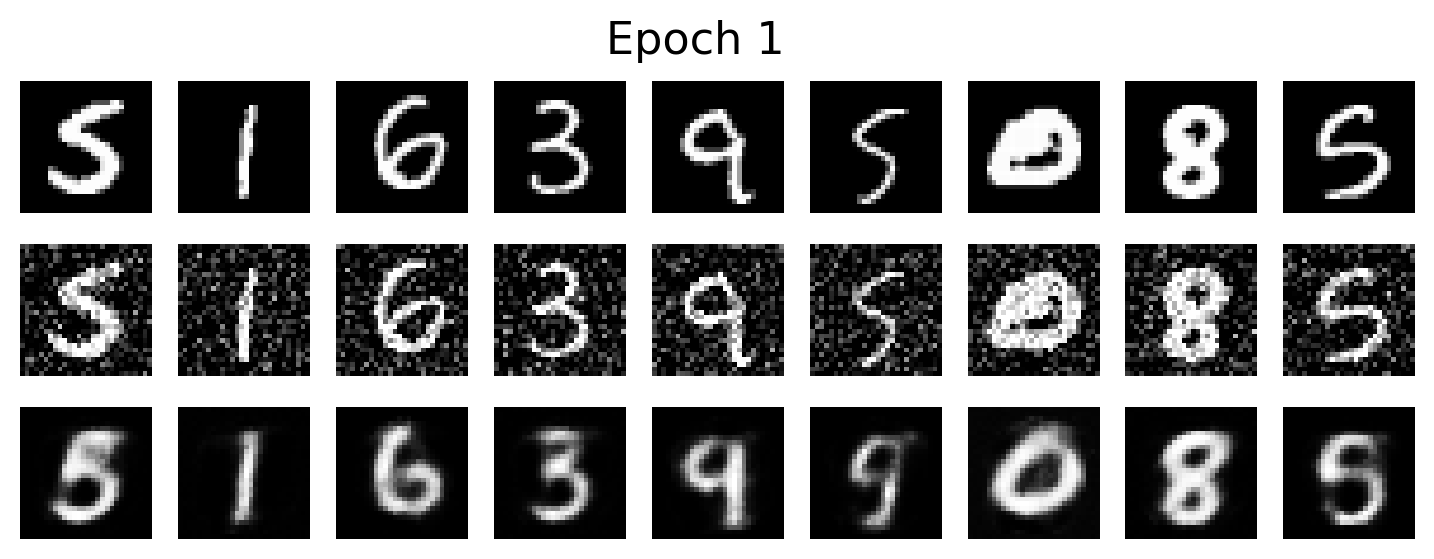

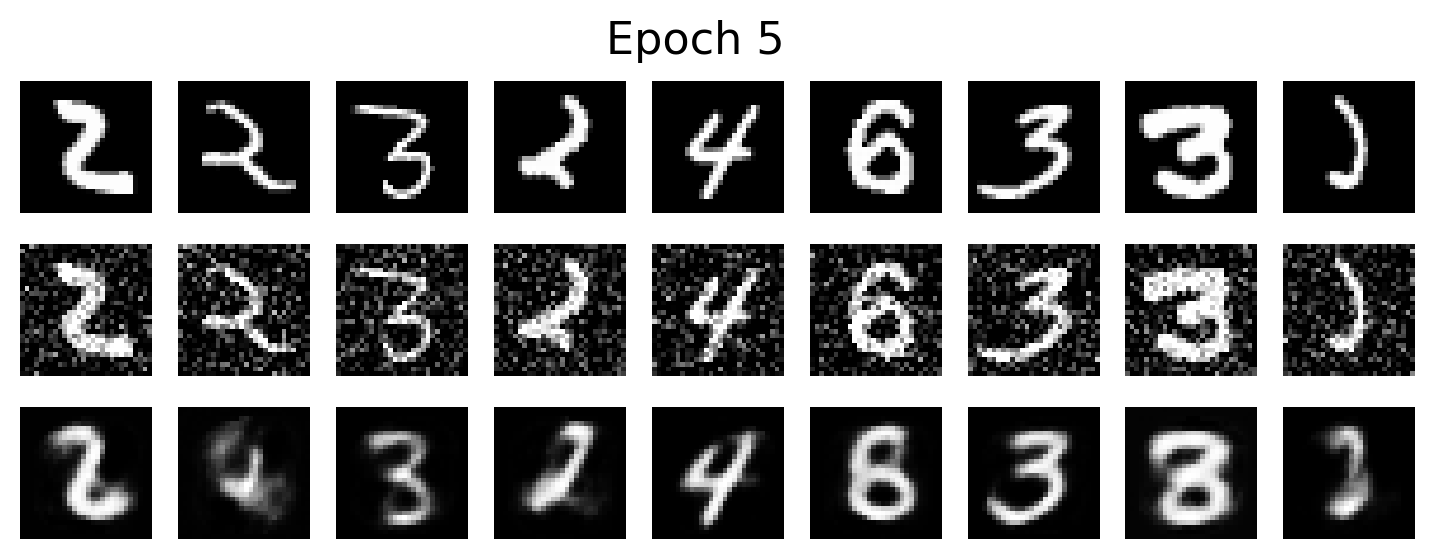

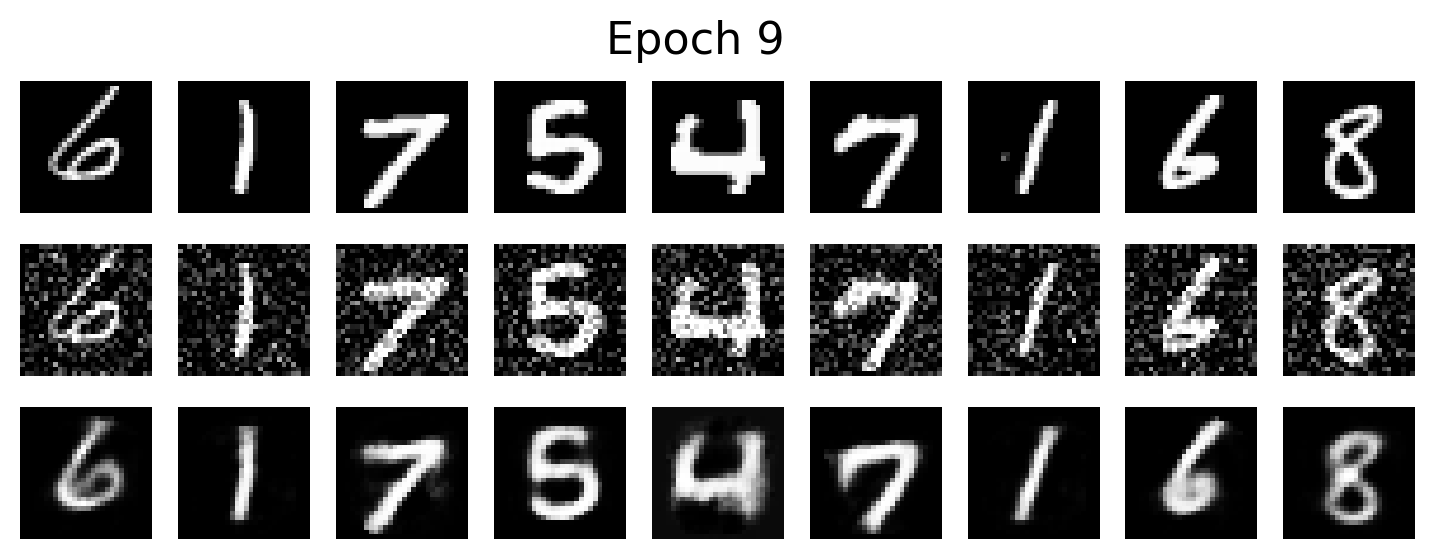

In [52]:
model = Autoencoder(100)
outputs = train_denoising_autoencoder(model, train_loader, criterion)
visualize_denoising_reconstructions(outputs)

### 4.2 FMNIST

Rerun the data download code if necessary.

In [46]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [47]:
criterion = nn.MSELoss()

Epoch [1/10], Loss: 0.0780, Total Loss: 0.1068, PSNR: 11.08
Epoch [2/10], Loss: 0.0863, Total Loss: 0.1080, PSNR: 10.64
Epoch [3/10], Loss: 0.0701, Total Loss: 0.0895, PSNR: 11.54
Epoch [4/10], Loss: 0.0756, Total Loss: 0.0940, PSNR: 11.21
Epoch [5/10], Loss: 0.0858, Total Loss: 0.1036, PSNR: 10.66
Epoch [6/10], Loss: 0.0827, Total Loss: 0.1000, PSNR: 10.83
Epoch [7/10], Loss: 0.0963, Total Loss: 0.1133, PSNR: 10.17
Epoch [8/10], Loss: 0.0751, Total Loss: 0.0920, PSNR: 11.24
Epoch [9/10], Loss: 0.0770, Total Loss: 0.0937, PSNR: 11.13
Epoch [10/10], Loss: 0.0735, Total Loss: 0.0900, PSNR: 11.34


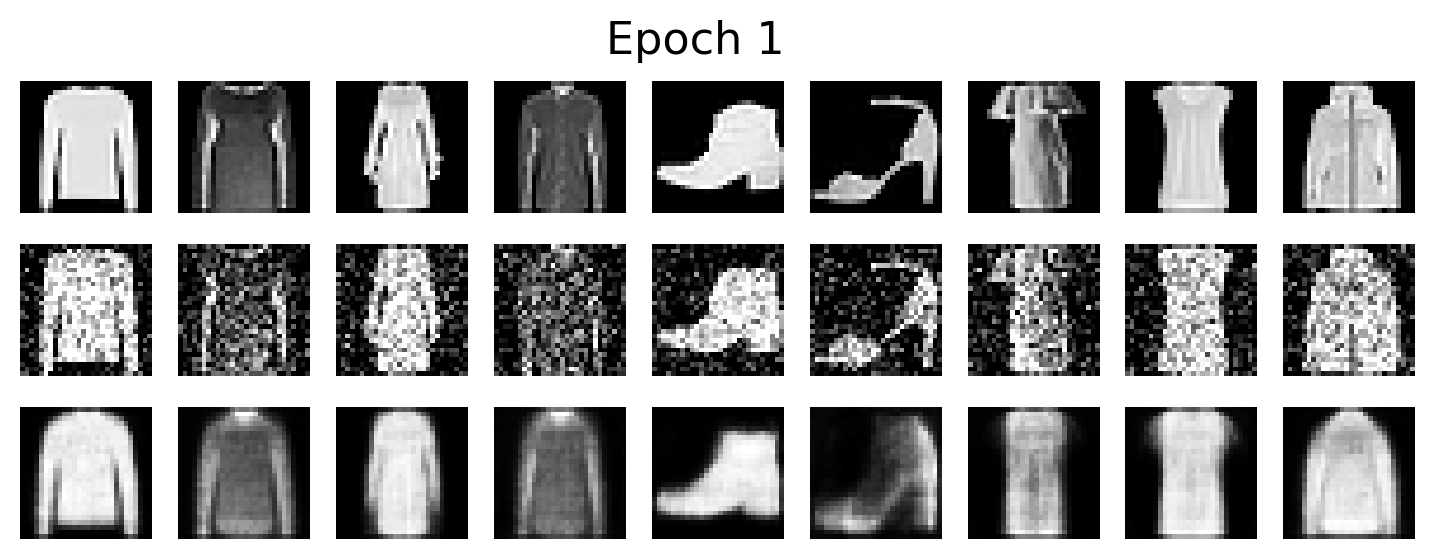

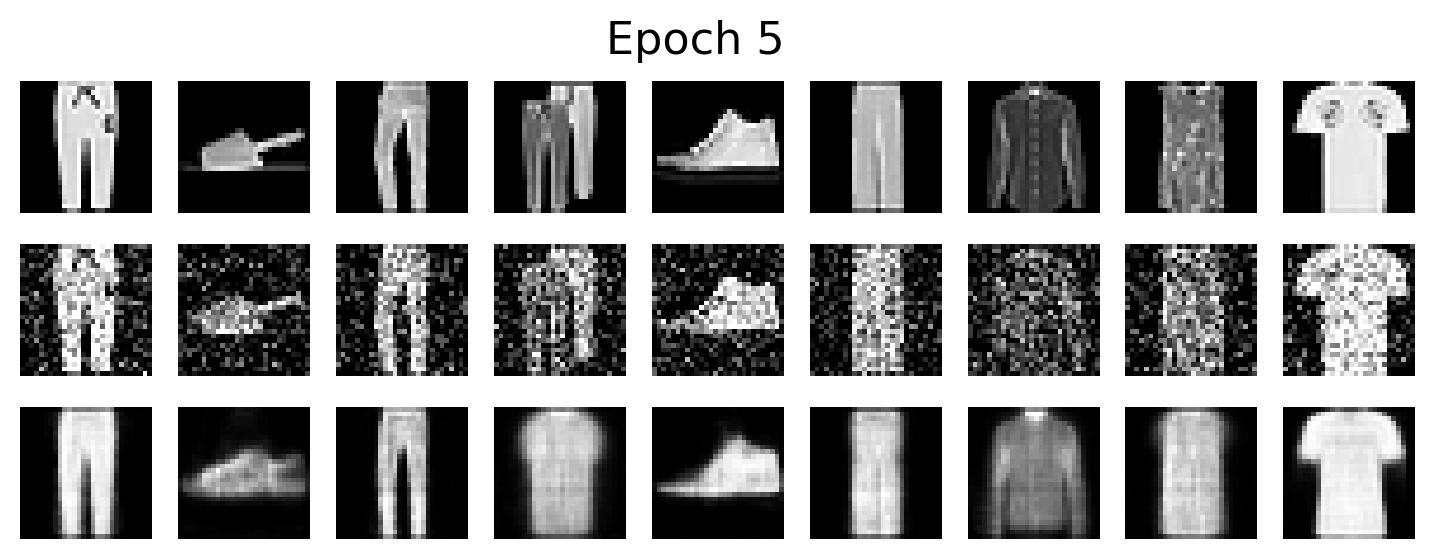

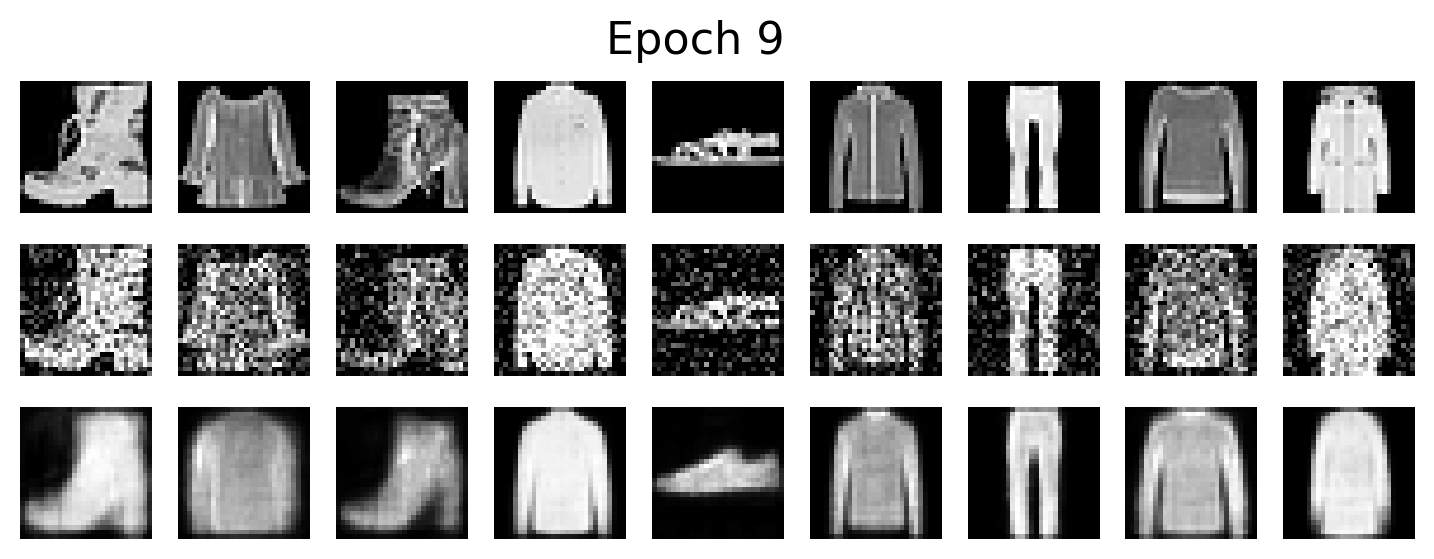

In [48]:
model = Autoencoder(15)
outputs = train_denoising_autoencoder(model, train_loader, criterion)
visualize_denoising_reconstructions(outputs)

Epoch [1/10], Loss: 0.0852, Total Loss: 0.1162, PSNR: 10.70
Epoch [2/10], Loss: 0.0897, Total Loss: 0.1134, PSNR: 10.47
Epoch [3/10], Loss: 0.0760, Total Loss: 0.0970, PSNR: 11.19
Epoch [4/10], Loss: 0.0891, Total Loss: 0.1084, PSNR: 10.50
Epoch [5/10], Loss: 0.0783, Total Loss: 0.0968, PSNR: 11.06
Epoch [6/10], Loss: 0.0727, Total Loss: 0.0905, PSNR: 11.39
Epoch [7/10], Loss: 0.0693, Total Loss: 0.0865, PSNR: 11.59
Epoch [8/10], Loss: 0.0795, Total Loss: 0.0964, PSNR: 11.00
Epoch [9/10], Loss: 0.0799, Total Loss: 0.0967, PSNR: 10.97
Epoch [10/10], Loss: 0.0784, Total Loss: 0.0949, PSNR: 11.06


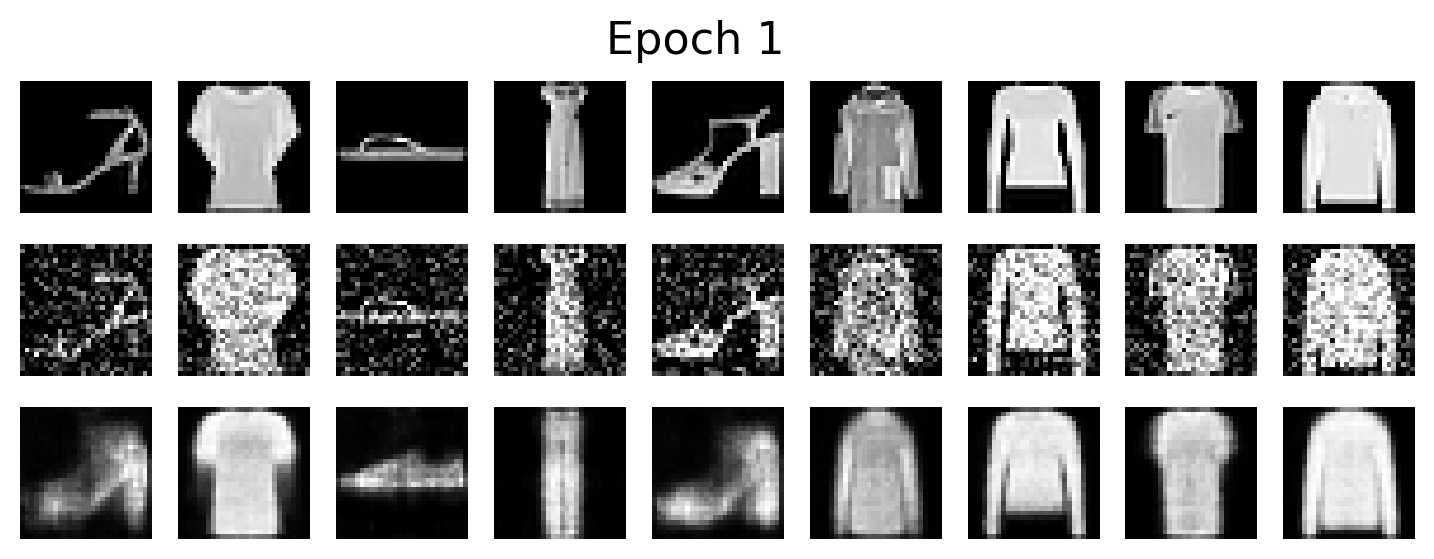

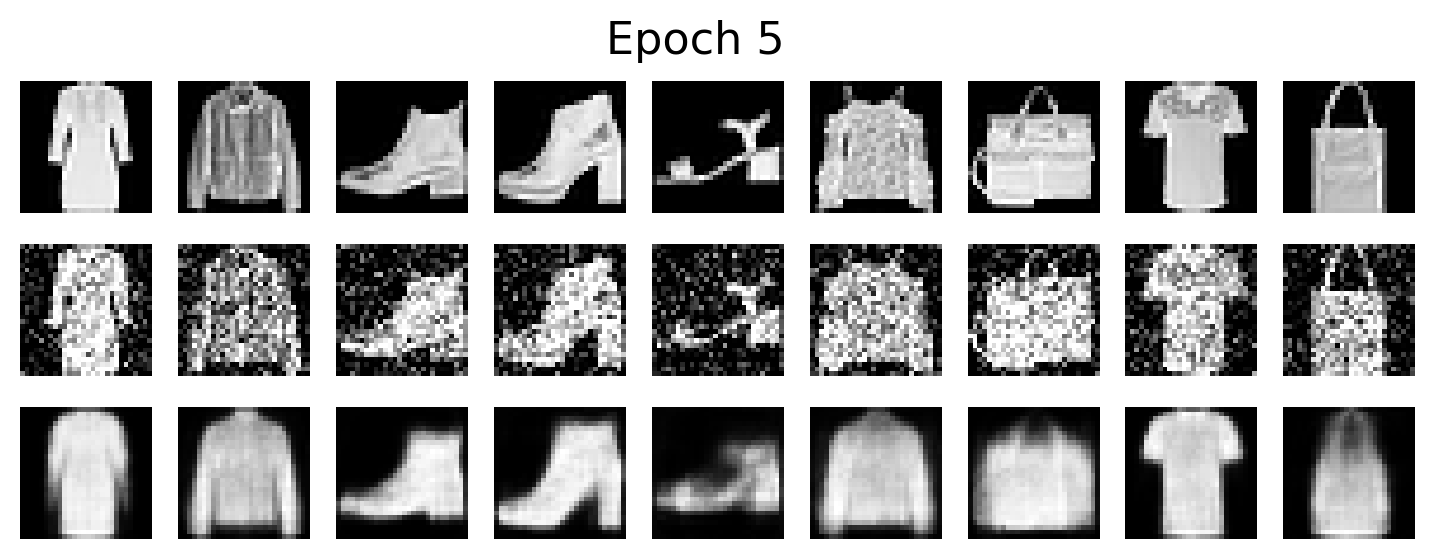

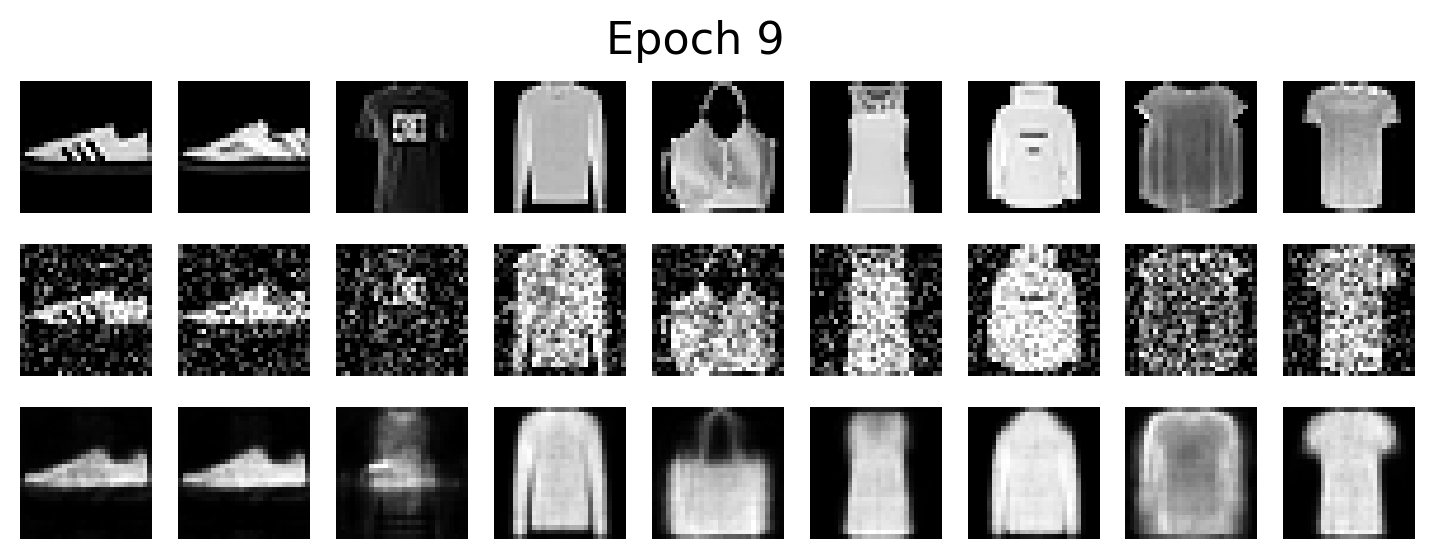

In [49]:
model = Autoencoder(100)
outputs = train_denoising_autoencoder(model, train_loader, criterion)
visualize_denoising_reconstructions(outputs)